In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, GRU
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

user_id activity        timestamp    x_axis     y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.694638  12.680544  0.503953   
1             33  Jogging   49106062271000  5.012288  11.264028  0.953424   
2             33  Jogging   49106112167000  4.903325  10.882658 -0.081722   
3             33  Jogging   49106222305000 -0.612916  18.496431  3.023717   
4             33  Jogging   49106332290000 -1.184970  12.108489  7.205164   
...          ...      ...              ...       ...        ...       ...   
1098200       19  Sitting  131623331483000  9.000000  -1.570000  1.690000   
1098201       19  Sitting  131623371431000  9.040000  -1.460000  1.730000   
1098202       19  Sitting  131623411592000  9.080000  -1.380000  1.690000   
1098203       19  Sitting  131623491487000  9.000000  -1.460000  1.730000   
1098204       19  Sitting  131623531465000  8.880000  -1.330000  1.610000   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

<Axes: xlabel='activity', ylabel='count'>

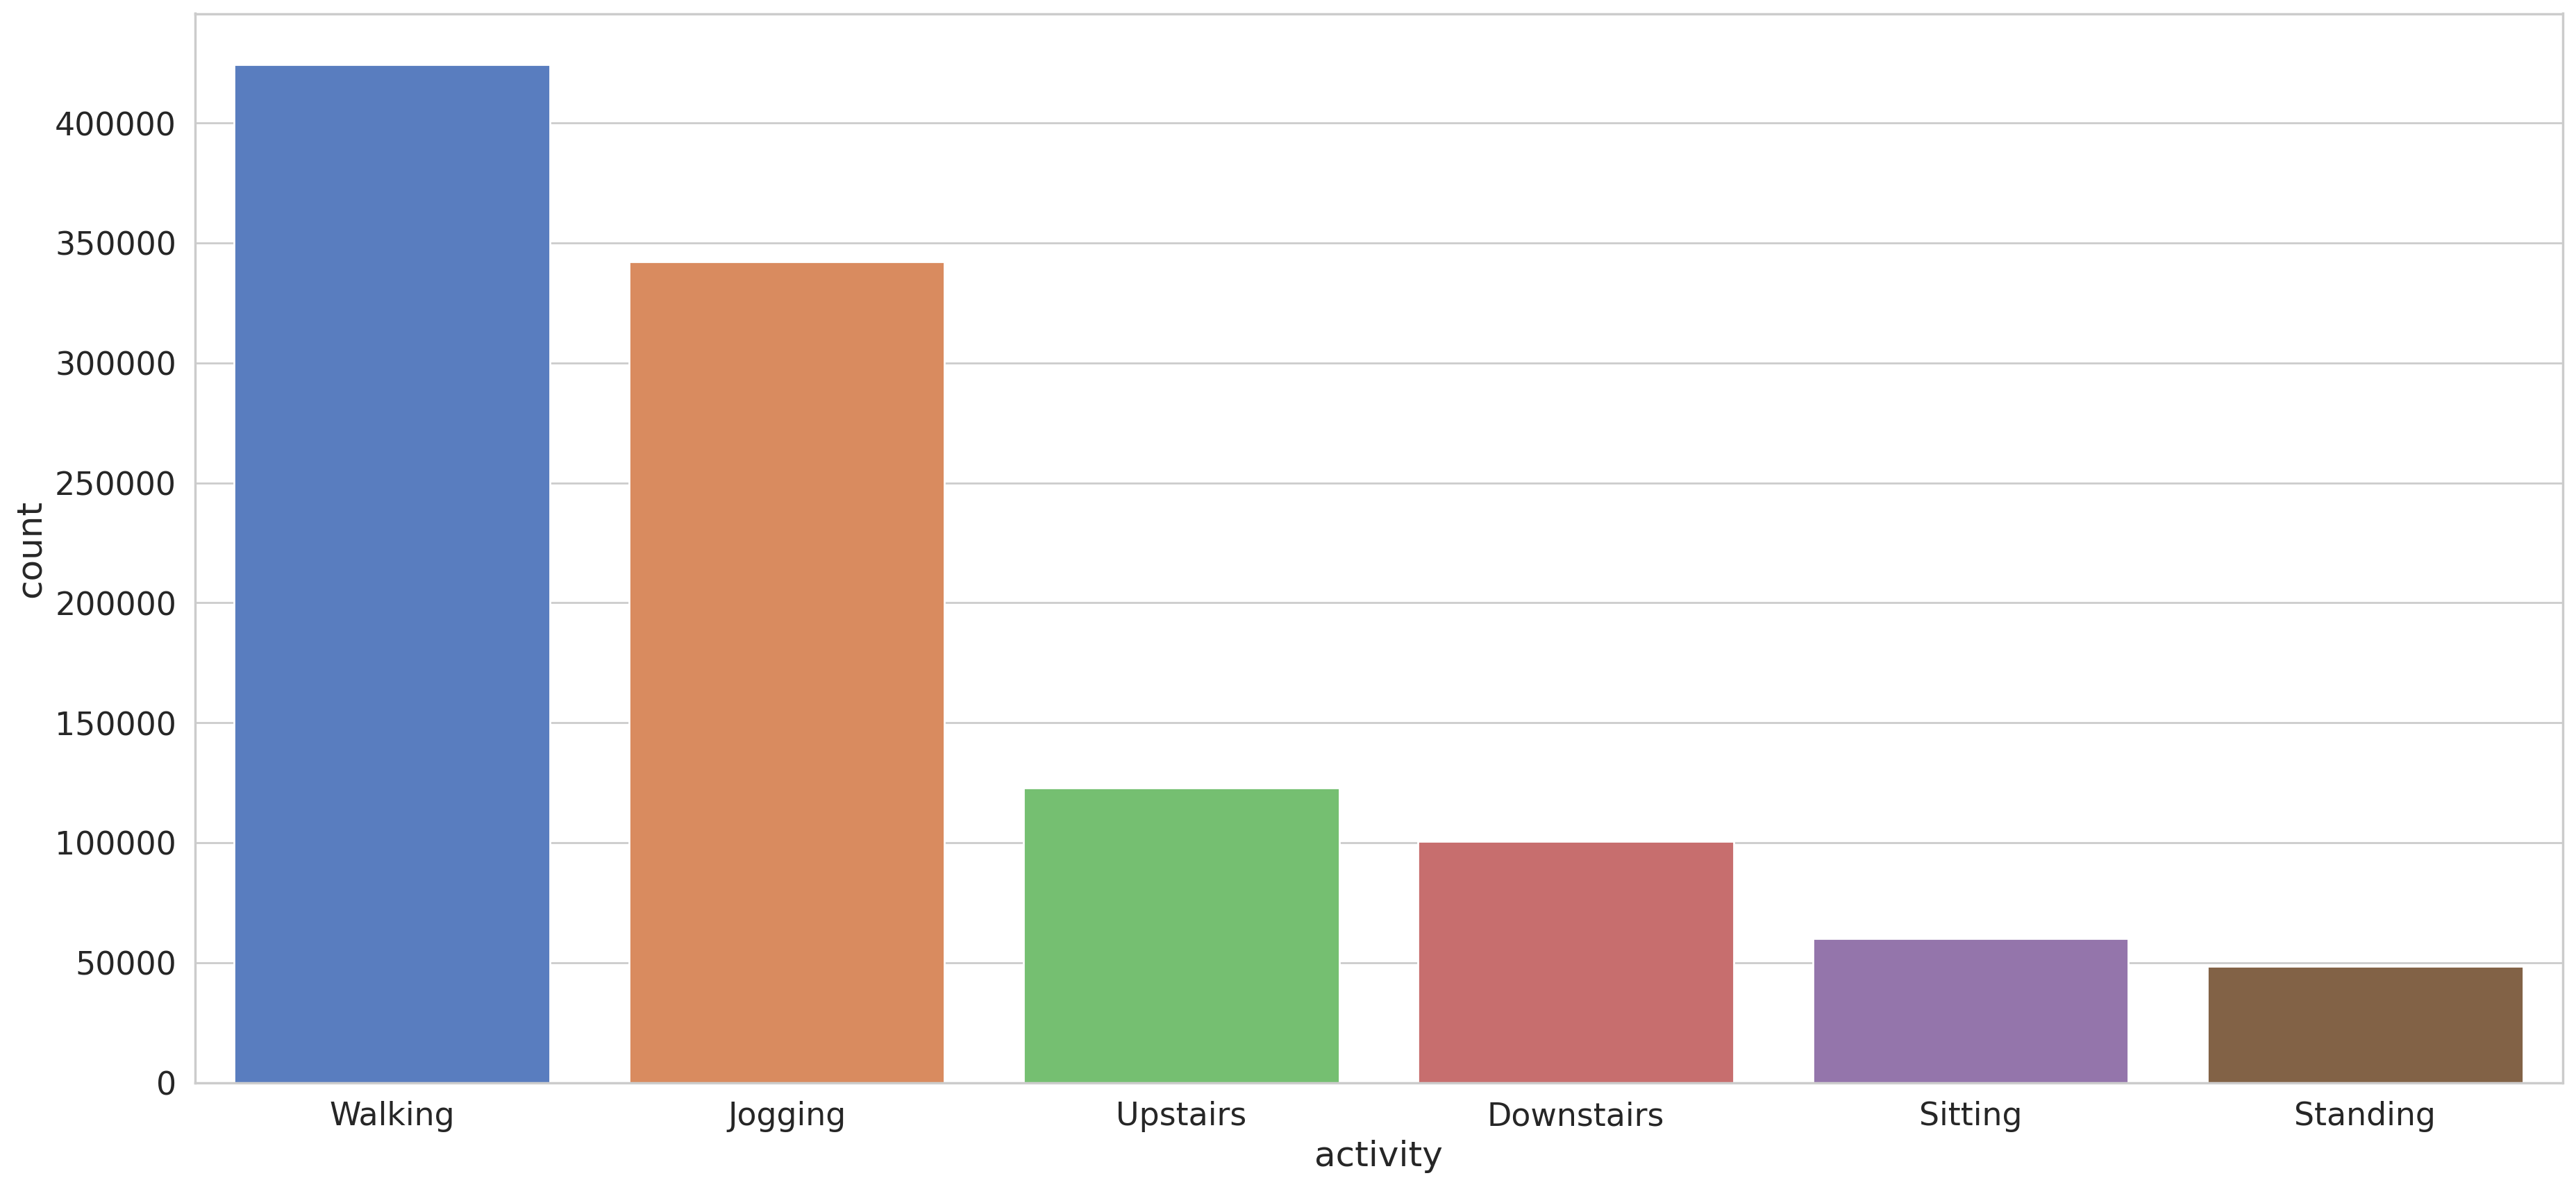

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

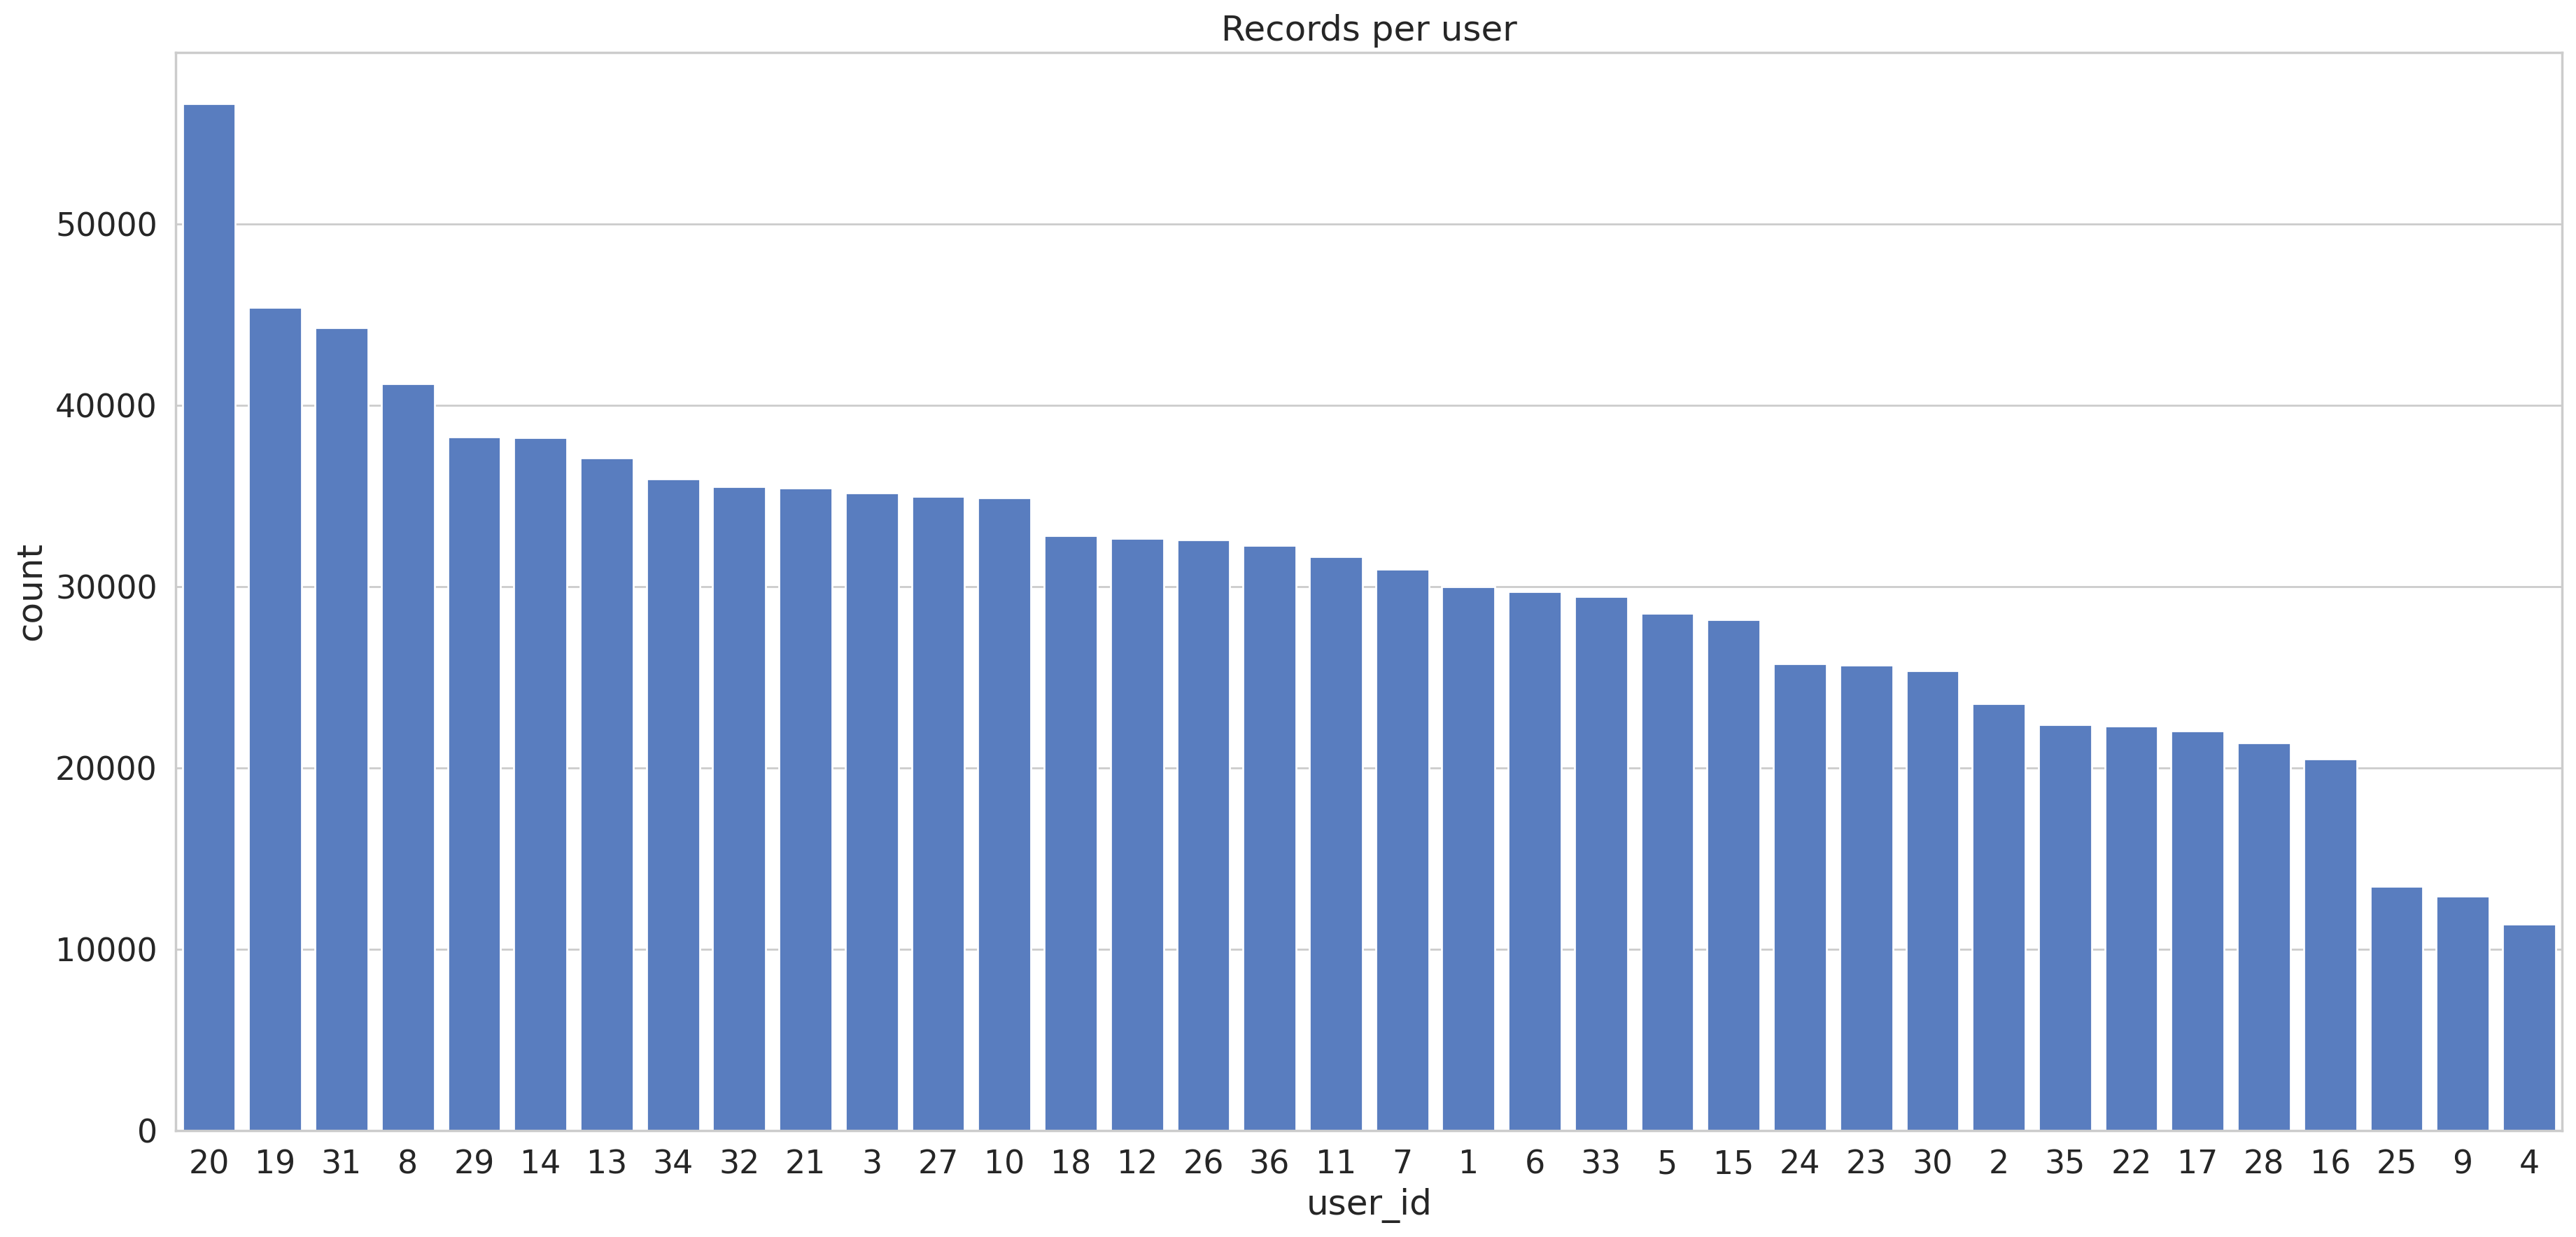

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


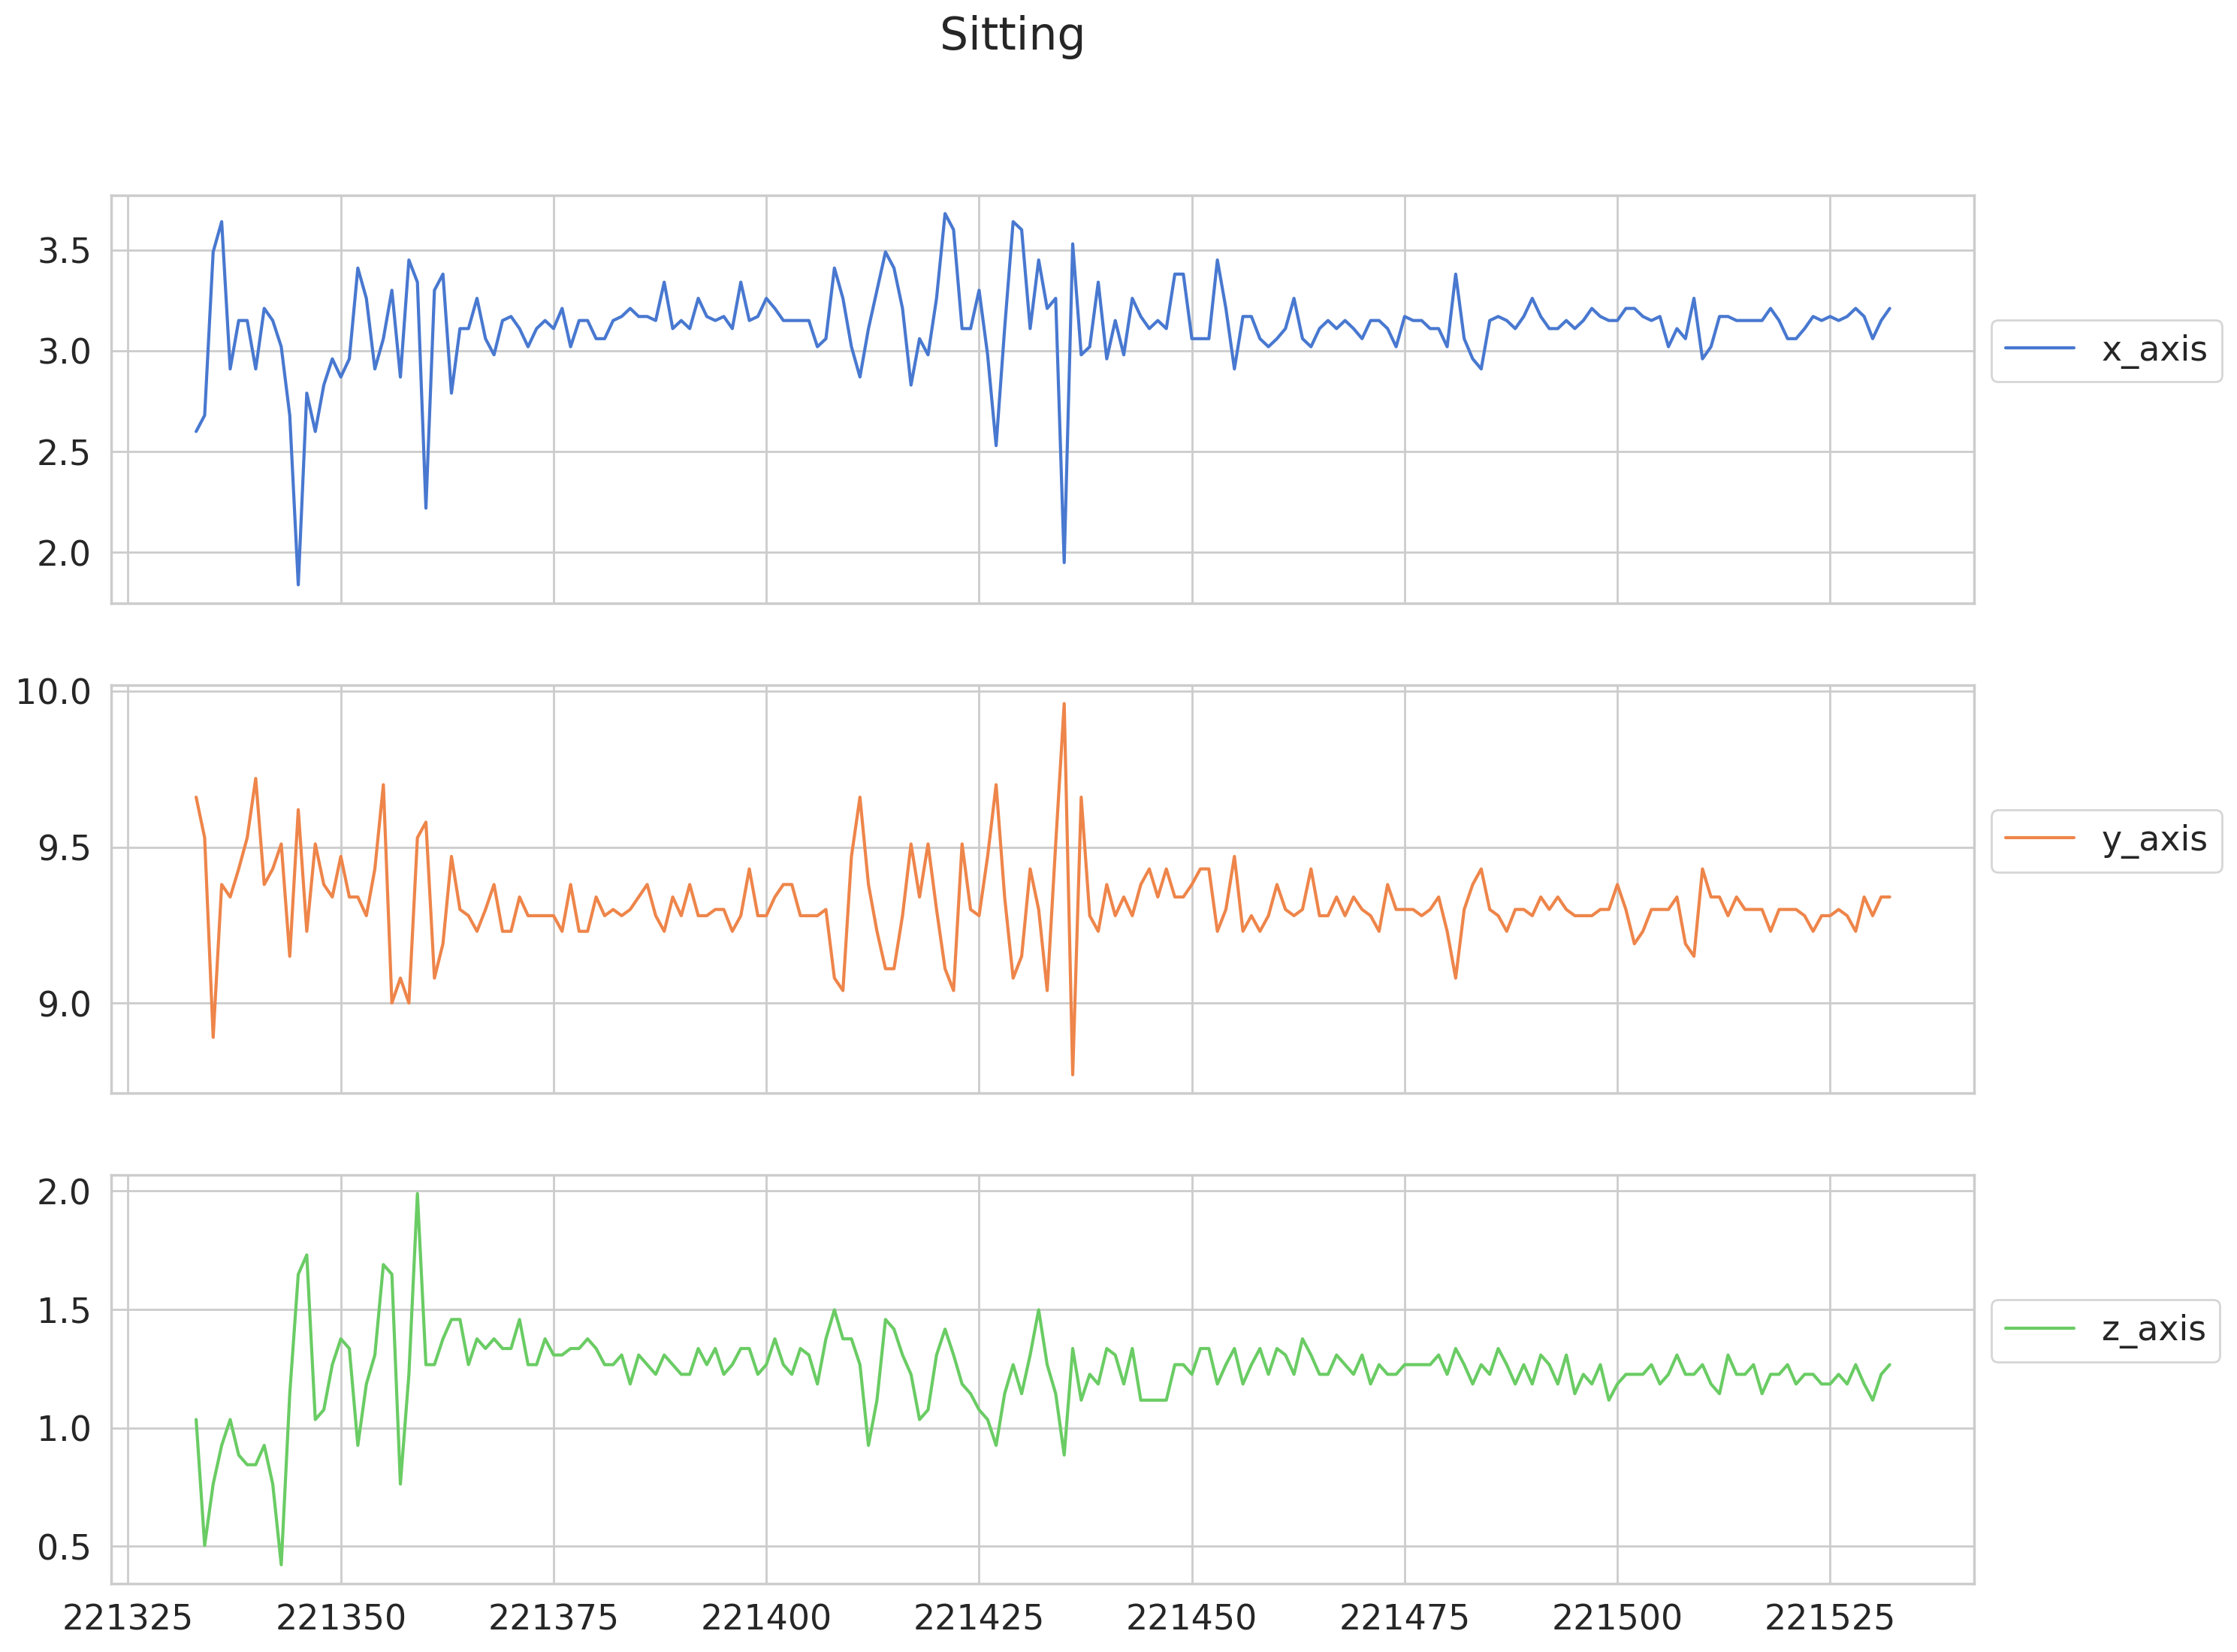

In [8]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


random_seed = 42

n_time_steps = 50

n_features = 3

step = 10

n_classes = 6

n_epochs = 50       

batch_size = 1024   

learning_rate = 0.0025

l2_loss = 0.0015


In [9]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


user_id activity        timestamp    x_axis    y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.131961  0.566215  0.102015   
1             33  Jogging   49106062271000  0.648740  0.397381  0.193001   
2             33  Jogging   49106112167000  0.633834  0.351926 -0.016543   
3             33  Jogging   49106222305000 -0.120782  1.259408  0.612089   
4             33  Jogging   49106332290000 -0.199038  0.498032  1.458535   
...          ...      ...              ...       ...       ...       ...   
1098200       19  Sitting  131623331483000  1.194254 -1.132300  0.342105   
1098201       19  Sitting  131623371431000  1.199726 -1.119190  0.350202   
1098202       19  Sitting  131623411592000  1.205198 -1.109654  0.342105   
1098203       19  Sitting  131623491487000  1.194254 -1.119190  0.350202   
1098204       19  Sitting  131623531465000  1.177839 -1.103695  0.325911   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

In [10]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 50
STEP = 10

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70281, 50, 3) (70281, 1)
(21964, 50, 3) (21964, 1)


In [11]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(70281, 50, 3) (70281, 6) (21964, 50, 3) (21964, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:

batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(50, 3, 6)

# LSTM1


In [13]:
model = Sequential()
# RNN layer
model.add(Bidirectional(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.build(input_shape=((X_train.shape[1], X_train.shape[2])))
#model.summary()

In [14]:
# validation_split = 0.1
batch_size = 1024

train_epochs = 10

history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
69/69 [==============================] - 11s 45ms/step - loss: 1.1178 - accuracy: 0.6252 - val_loss: 0.7813 - val_accuracy: 0.7368
Epoch 2/10
69/69 [==============================] - 2s 31ms/step - loss: 0.6759 - accuracy: 0.7664 - val_loss: 0.5443 - val_accuracy: 0.7991
Epoch 3/10
69/69 [==============================] - 2s 31ms/step - loss: 0.5275 - accuracy: 0.8112 - val_loss: 0.4919 - val_accuracy: 0.8175
Epoch 4/10
69/69 [==============================] - 2s 31ms/step - loss: 0.4804 - accuracy: 0.8251 - val_loss: 0.4190 - val_accuracy: 0.8422
Epoch 5/10
69/69 [==============================] - 2s 34ms/step - loss: 0.4186 - accuracy: 0.8435 - val_loss: 0.3720 - val_accuracy: 0.8607
Epoch 6/10
69/69 [==============================] - 2s 33ms/step - loss: 0.3777 - accuracy: 0.8583 - val_loss: 0.3364 - val_accuracy: 0.8739
Epoch 7/10
69/69 [==============================] - 2s 34ms/step - loss: 0.3324 - accuracy: 0.8782 - val_loss: 0.2887 - val_accuracy: 0.8962
Epoch 8/10
6

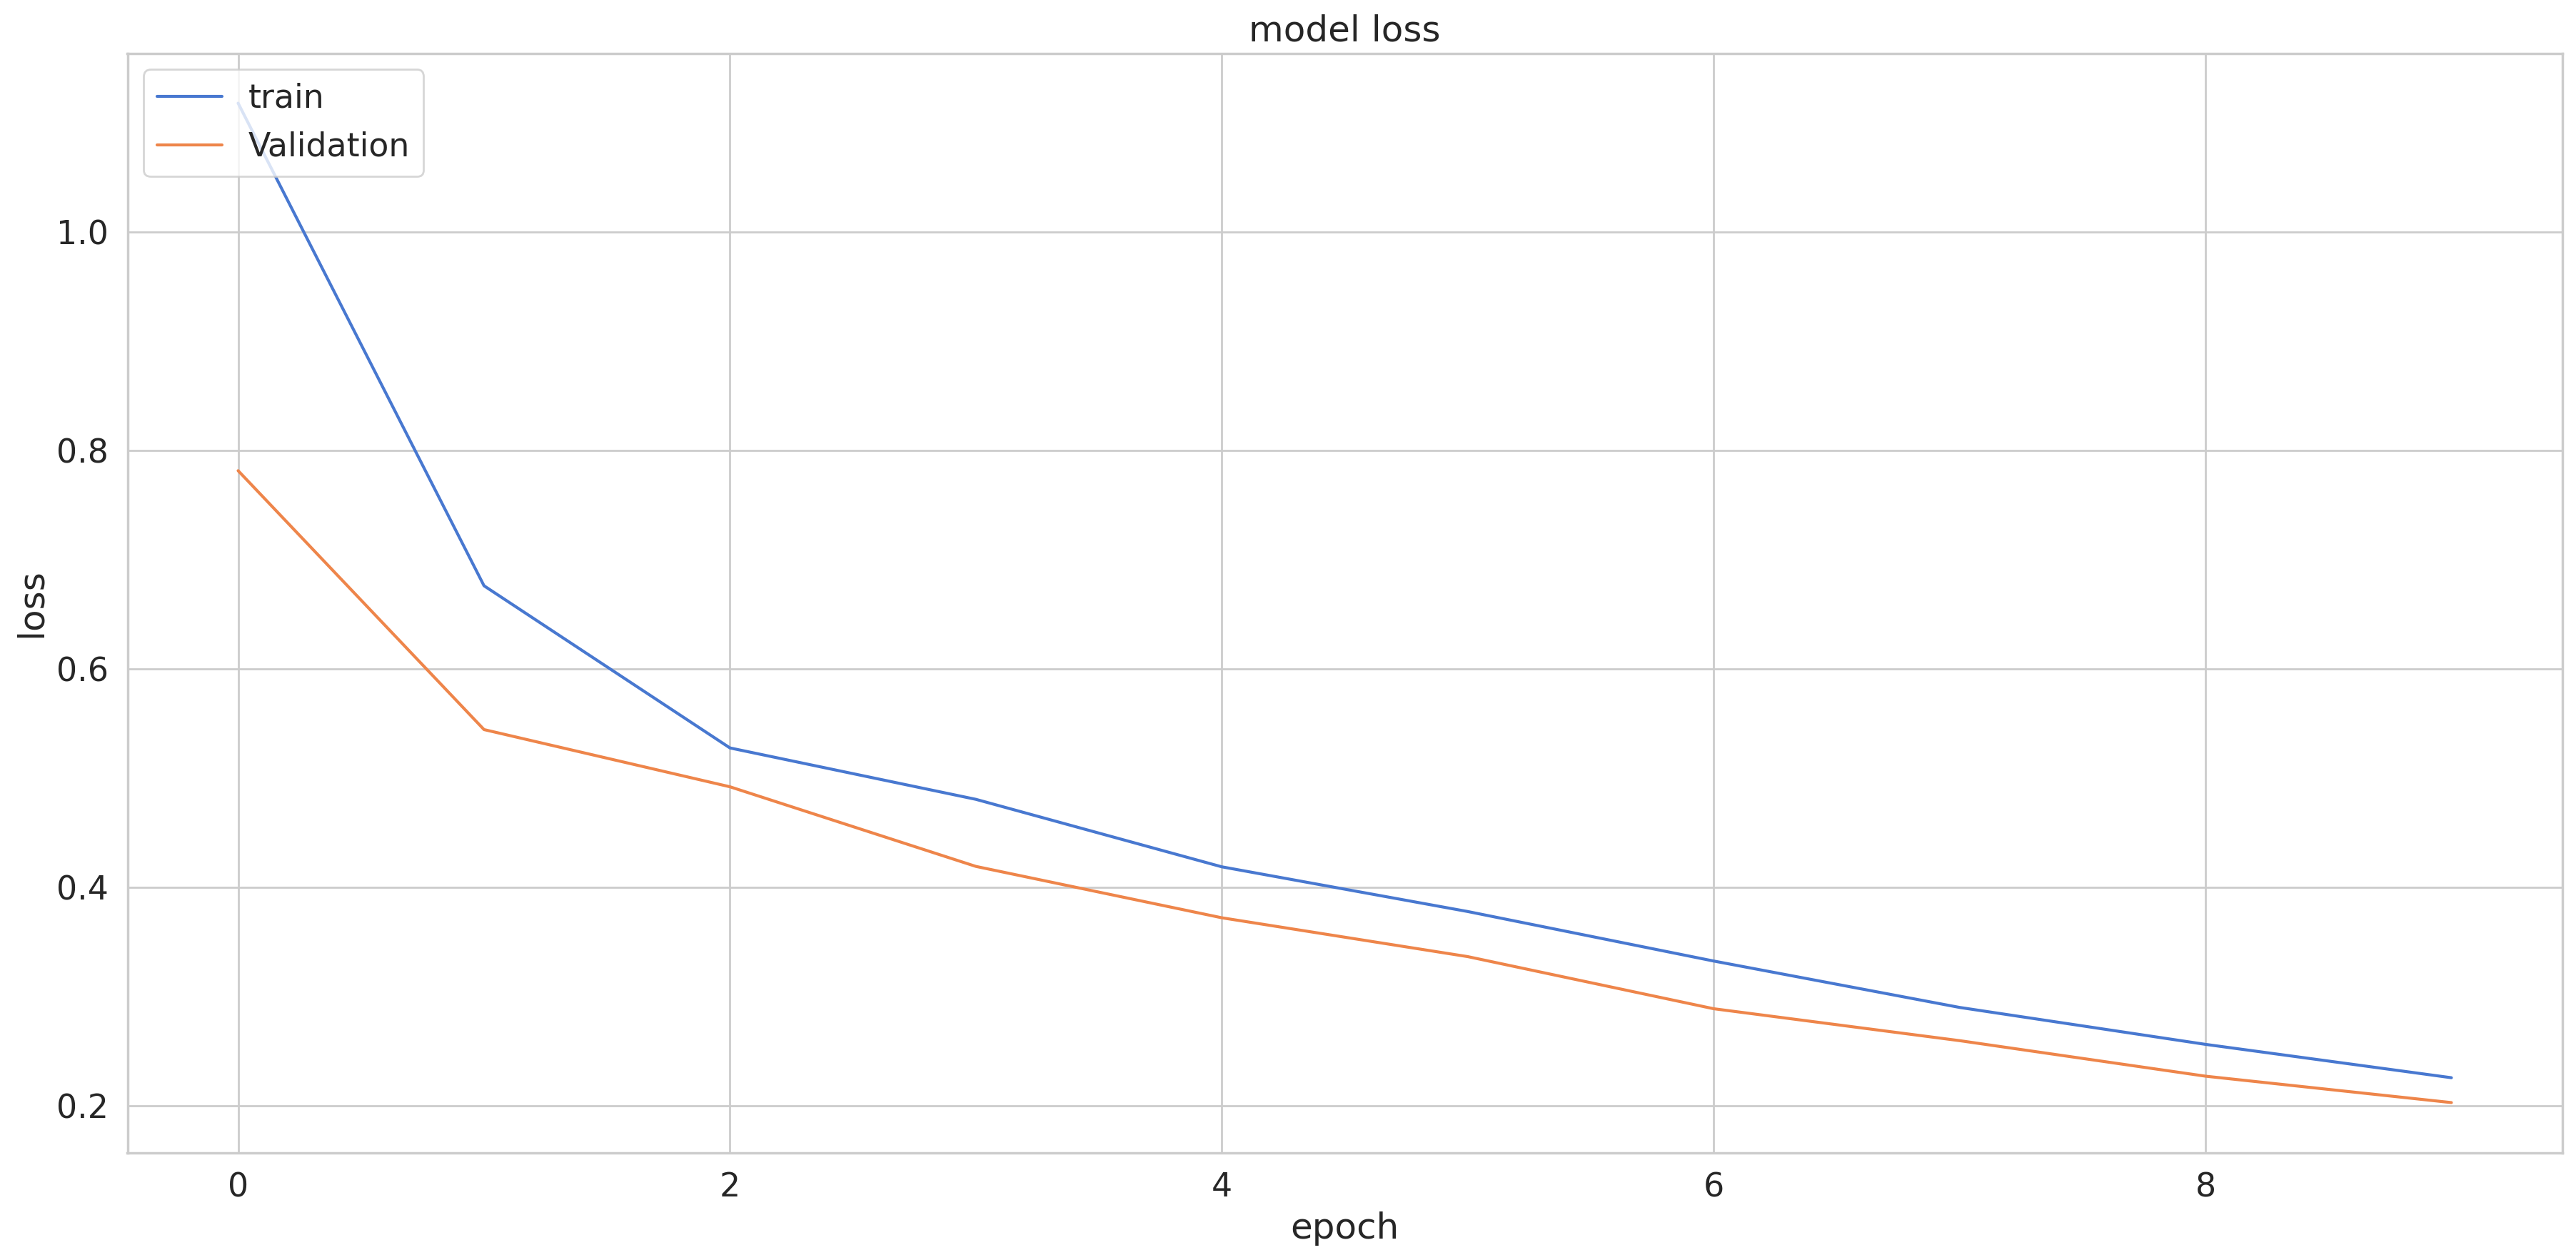

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

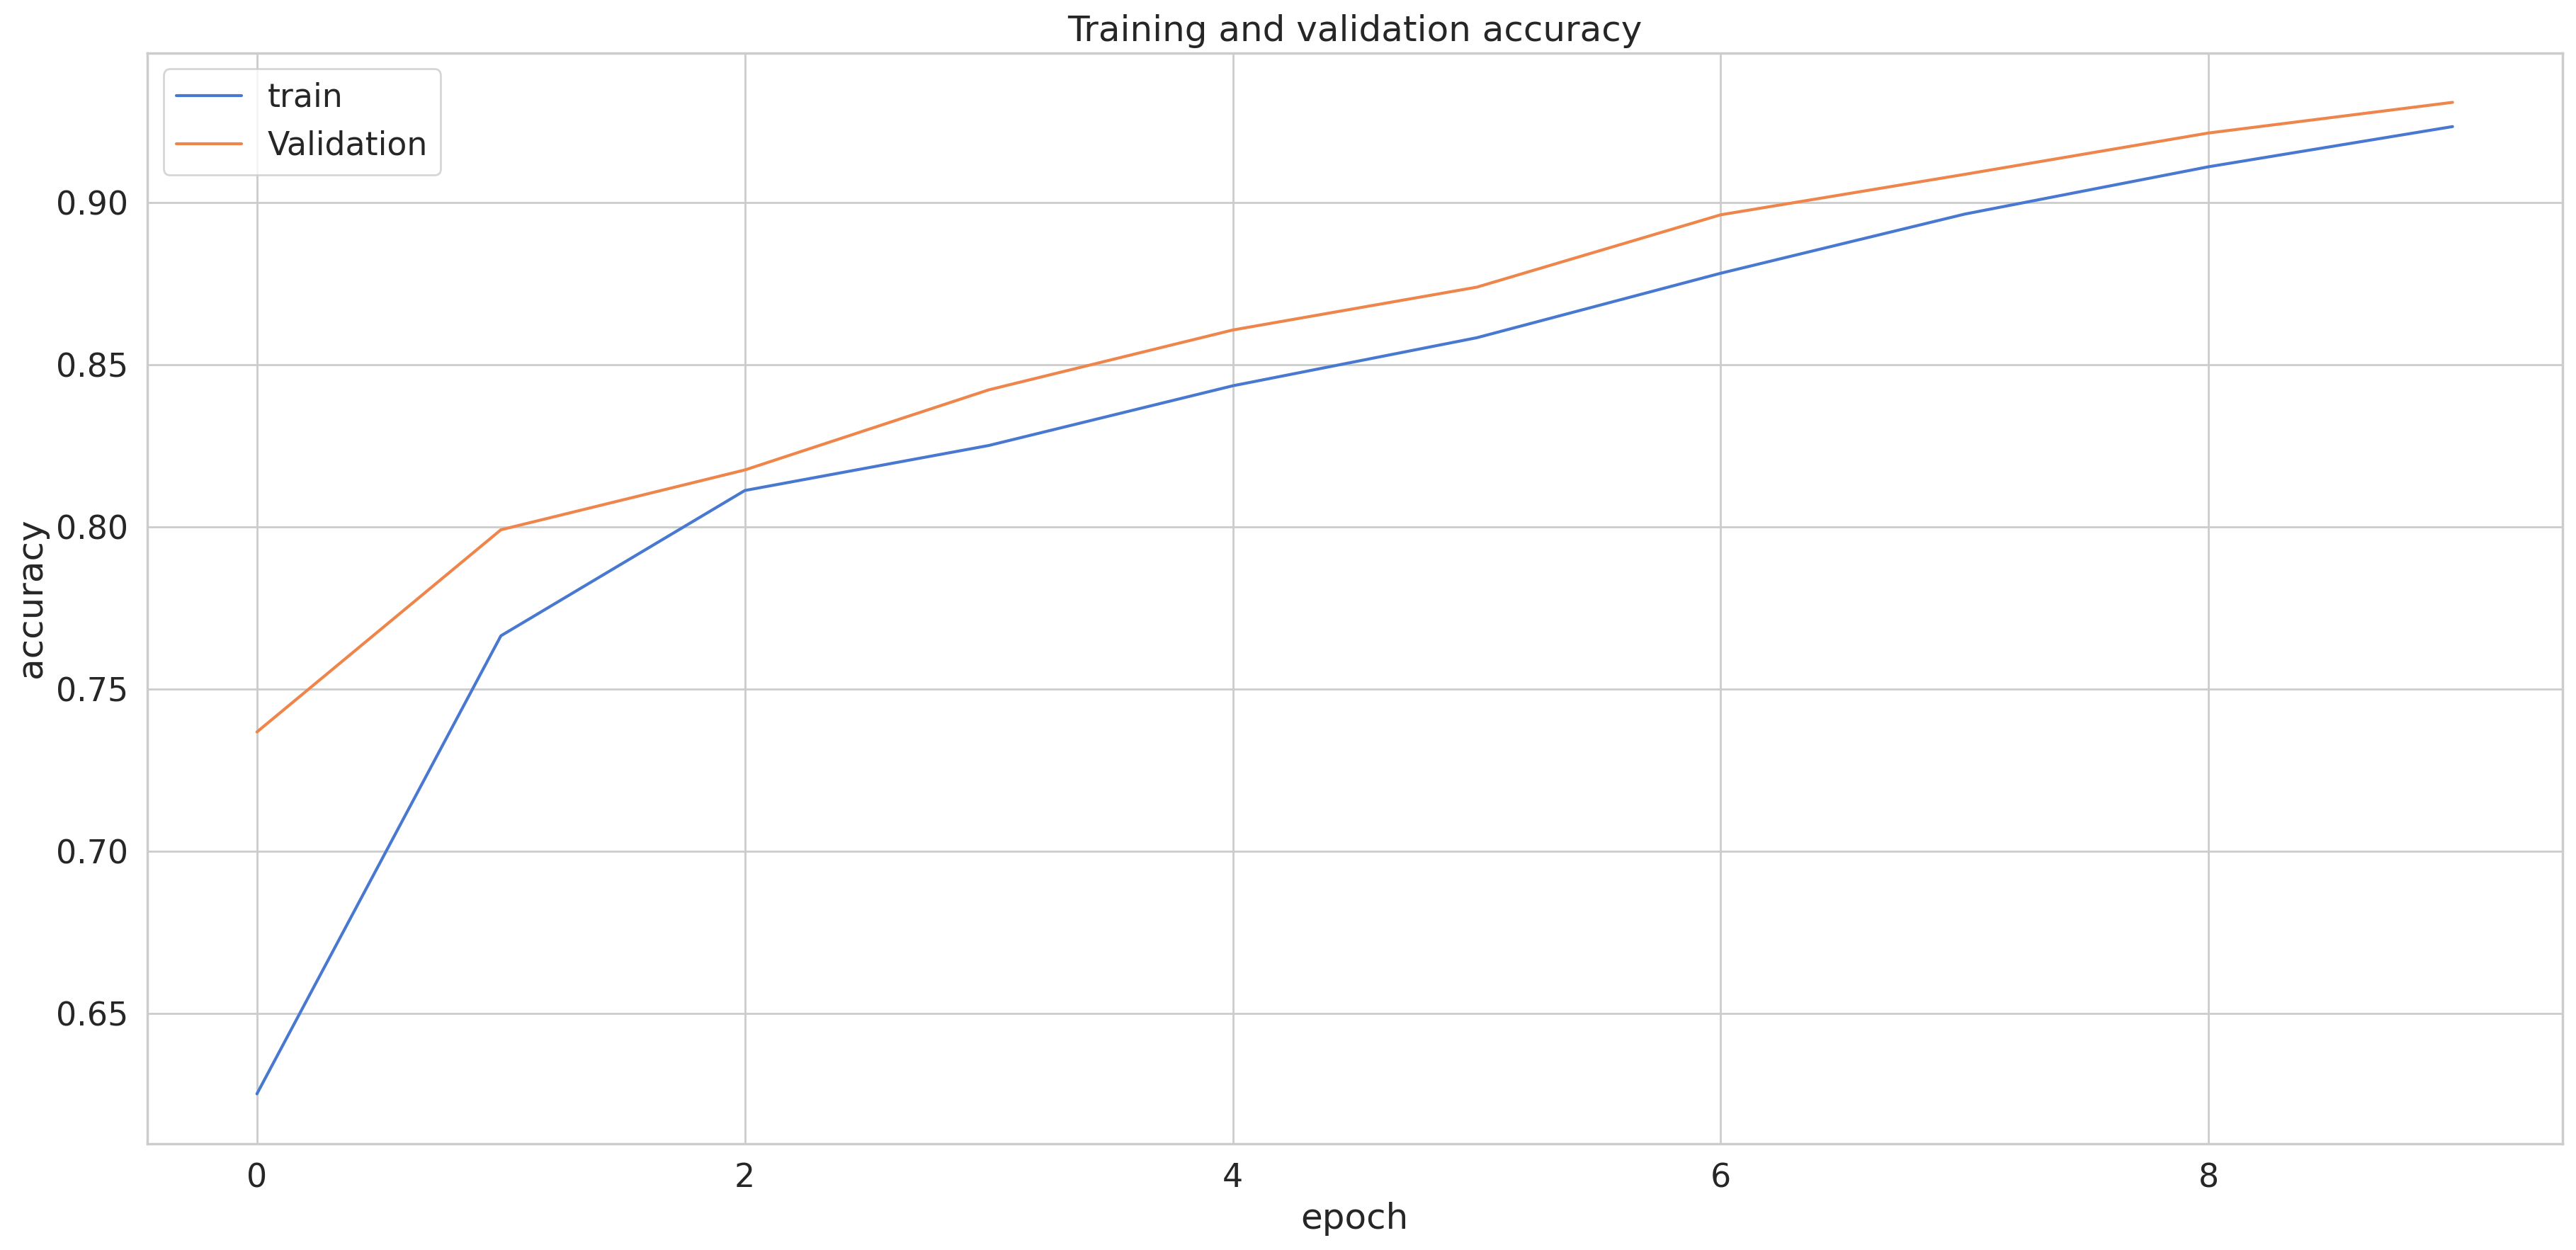

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 4s 5ms/step
f1_score =  0.9325438059657333
0.9330723001274813
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8489
           1       0.97      0.98      0.97      6844
           2       0.84      0.78      0.81      2458
           3       0.77      0.79      0.78      2007
           4       0.98      0.96      0.97      1198
           5       0.93      0.99      0.96       968

    accuracy                           0.93     21964
   macro avg       0.91      0.91      0.91     21964
weighted avg       0.93      0.93      0.93     21964



<Axes: >

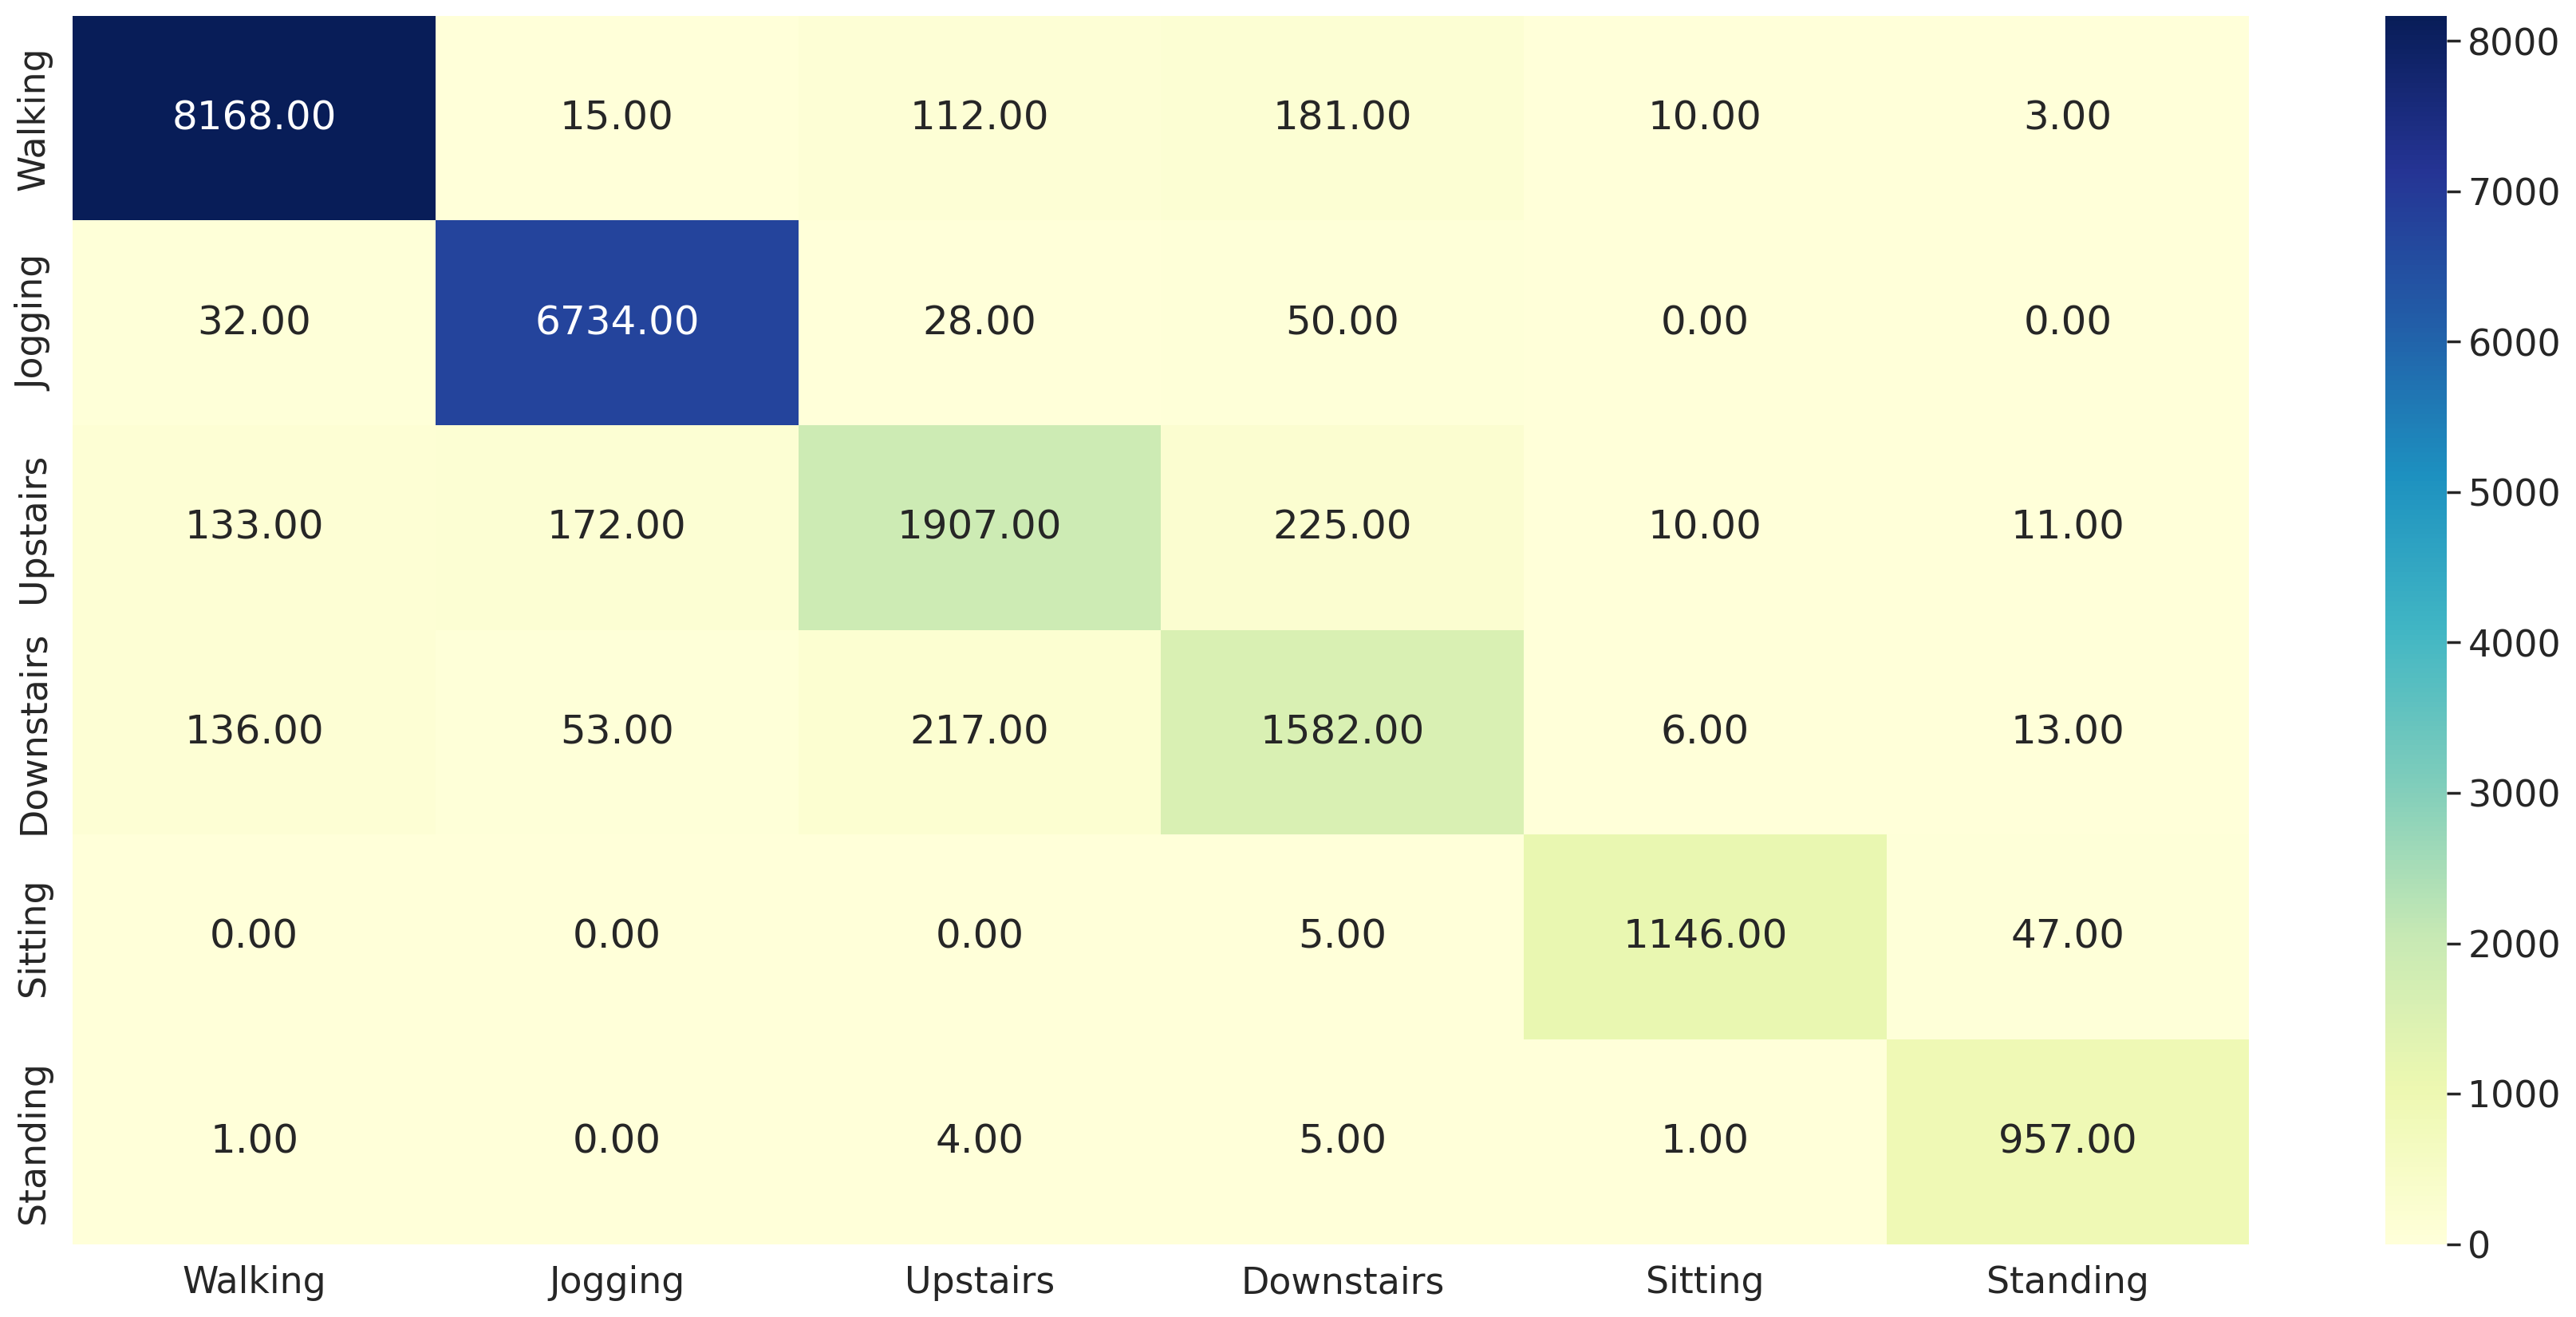

In [17]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM2

In [ ]:
model = Sequential()
# RNN layer
model.add(Bidirectional(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 50, 256)           135168    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 6)                

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 31s 37ms/step - loss: 0.5625 - accuracy: 0.8014 - val_loss: 0.3901 - val_accuracy: 0.8804
Epoch 2/10
550/550 [==============================] - 11s 20ms/step - loss: 0.2254 - accuracy: 0.9241 - val_loss: 0.1738 - val_accuracy: 0.9413
Epoch 3/10
550/550 [==============================] - 11s 20ms/step - loss: 0.1533 - accuracy: 0.9505 - val_loss: 0.2606 - val_accuracy: 0.9068
Epoch 4/10
550/550 [==============================] - 11s 20ms/step - loss: 0.1334 - accuracy: 0.9568 - val_loss: 0.1098 - val_accuracy: 0.9647
Epoch 5/10
550/550 [==============================] - 11s 20ms/step - loss: 0.0995 - accuracy: 0.9677 - val_loss: 0.1062 - val_accuracy: 0.9661
Epoch 6/10
550/550 [==============================] - 11s 20ms/step - loss: 0.0870 - accuracy: 0.9720 - val_loss: 0.0864 - val_accuracy: 0.9718
Epoch 7/10
550/550 [==============================] - 11s 20ms/step - loss: 0.0714 - accuracy: 0.9768 - val_loss: 0.0629 - val_accuracy:

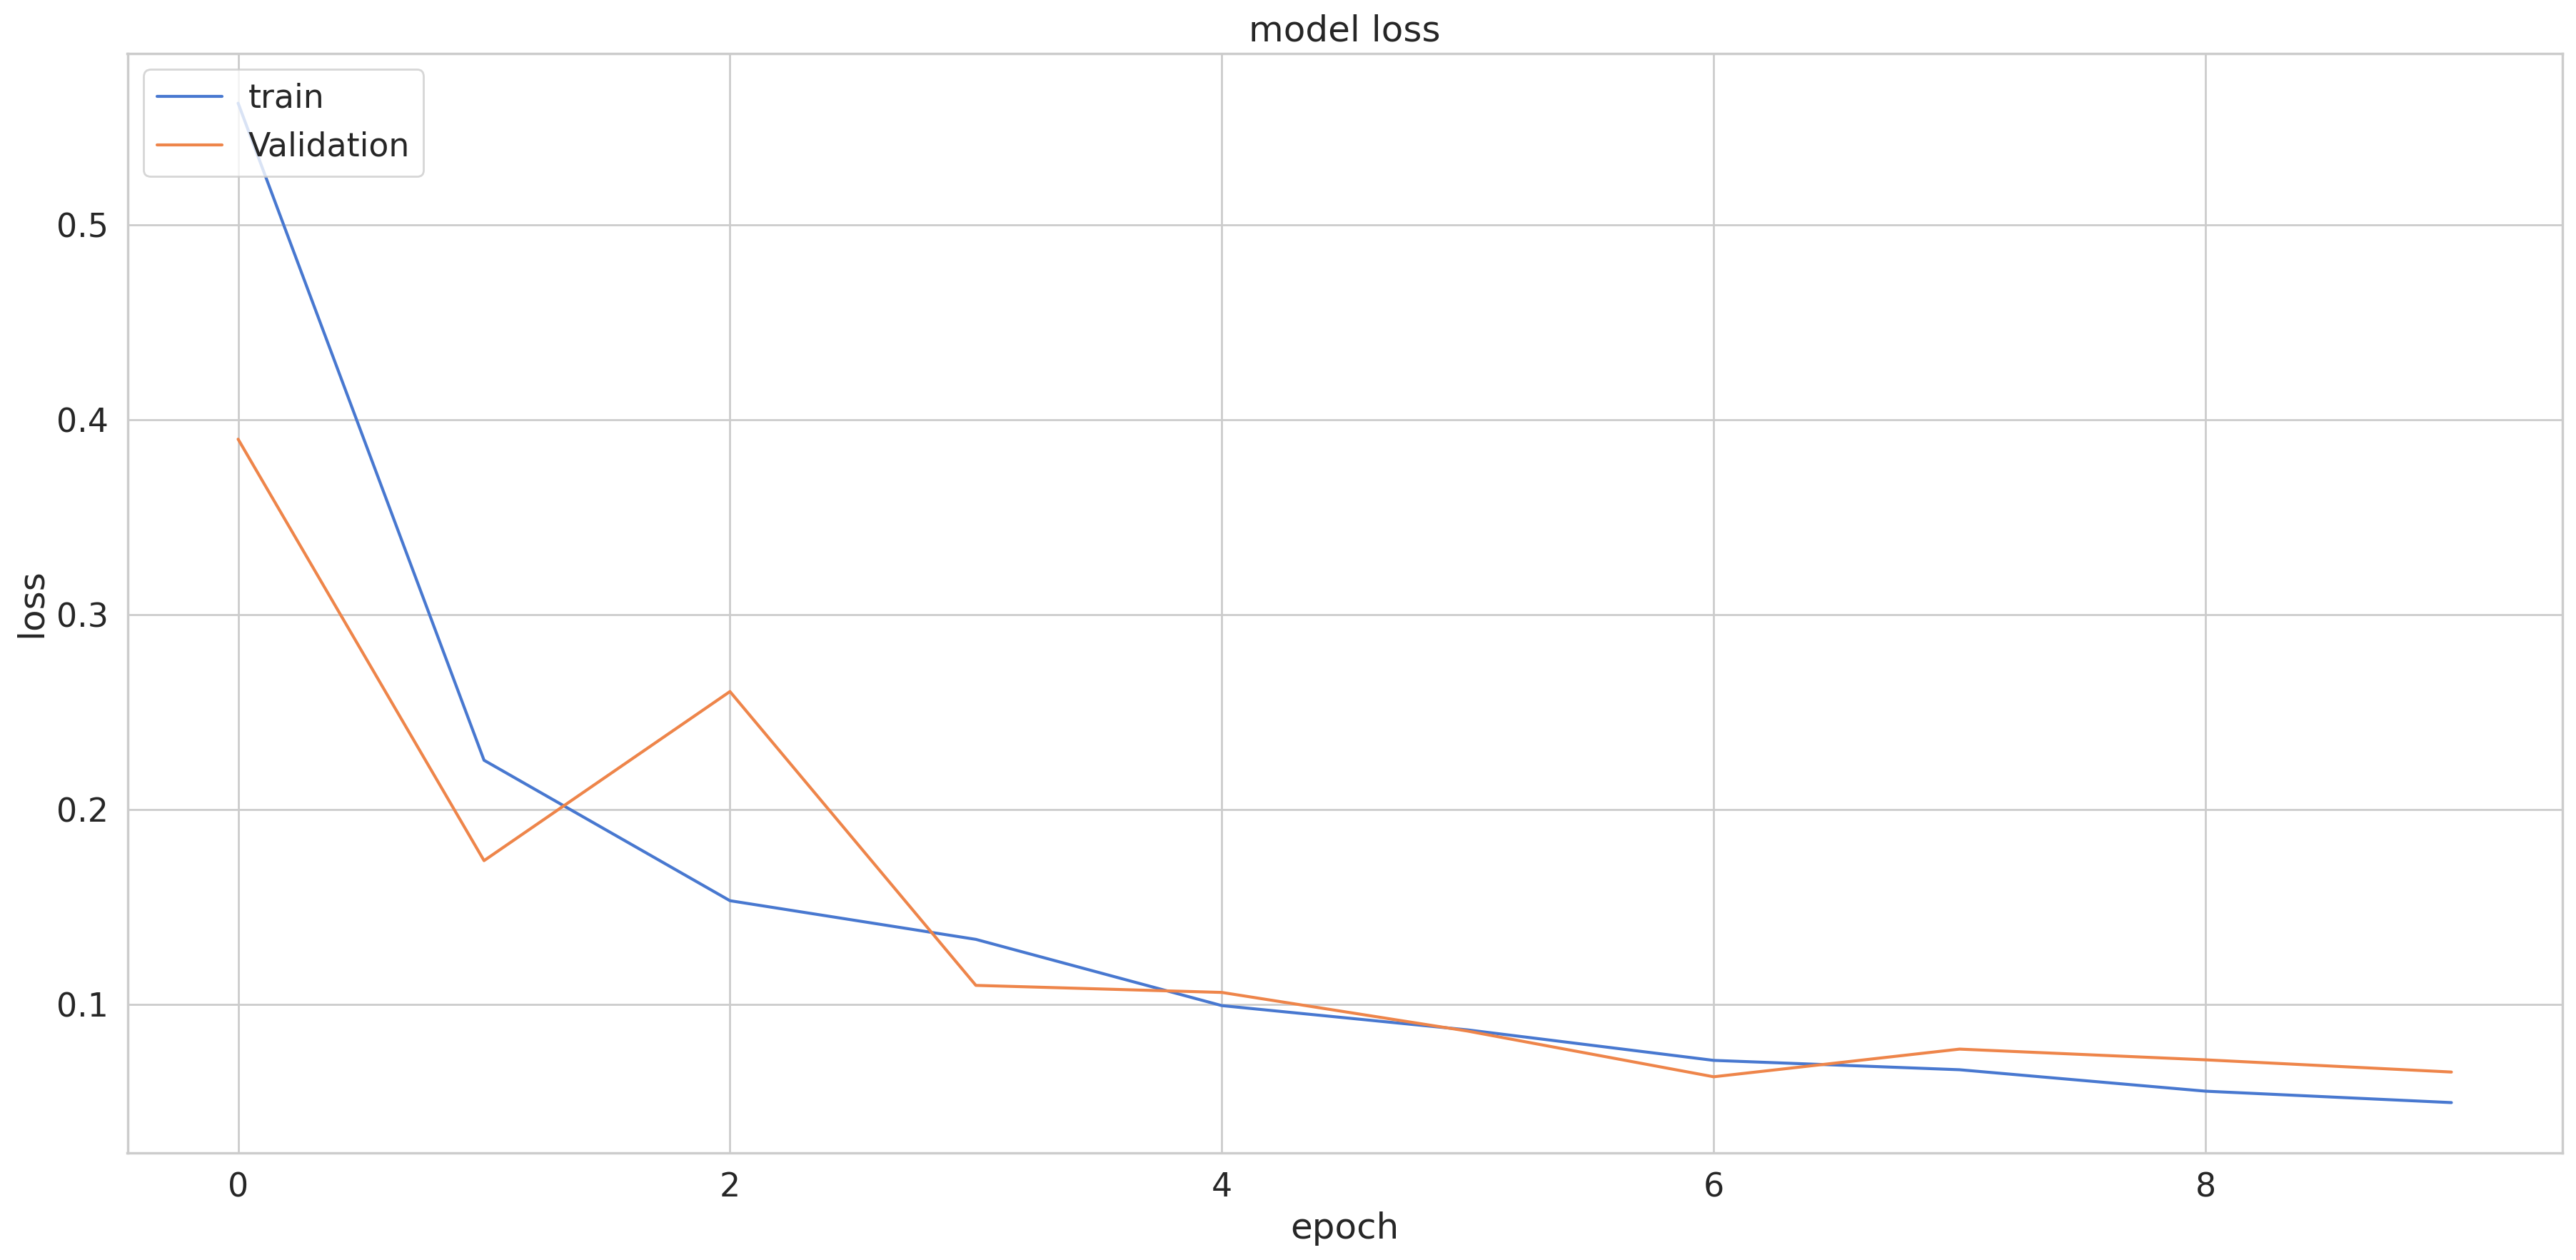

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

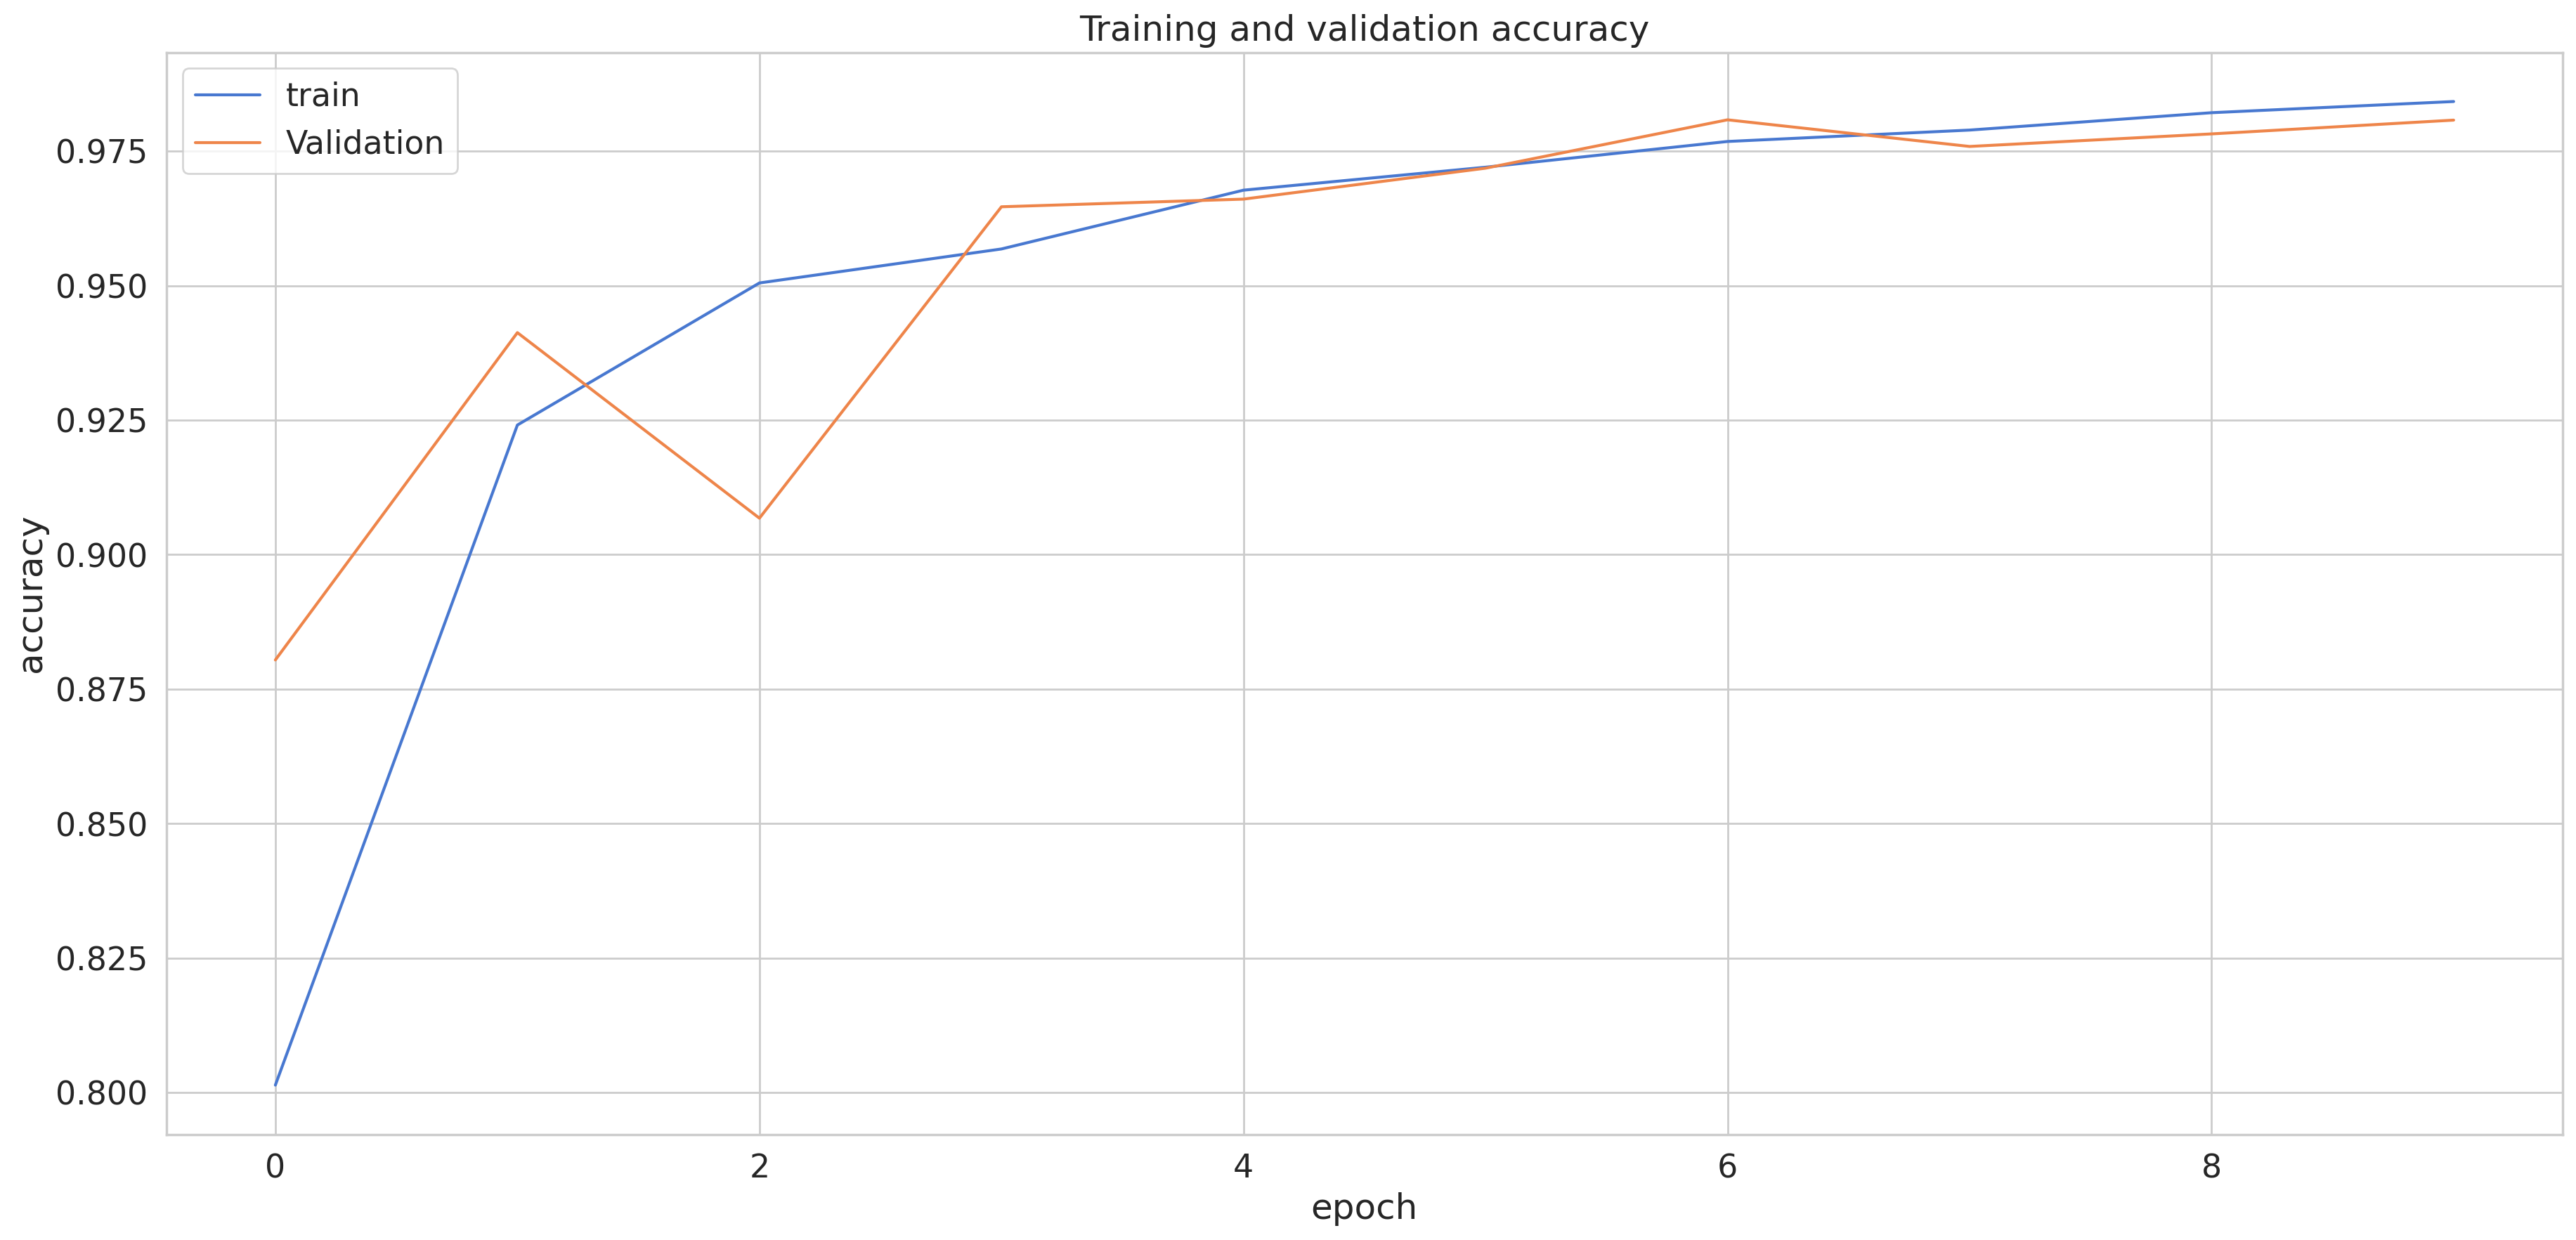

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 6s 7ms/step
f1_score =  0.9810910952850141
0.9811054452740848
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8489
           1       0.99      0.99      0.99      6844
           2       0.95      0.94      0.94      2458
           3       0.95      0.94      0.95      2007
           4       0.99      0.99      0.99      1198
           5       0.94      0.99      0.96       968

    accuracy                           0.98     21964
   macro avg       0.97      0.97      0.97     21964
weighted avg       0.98      0.98      0.98     21964



<Axes: >

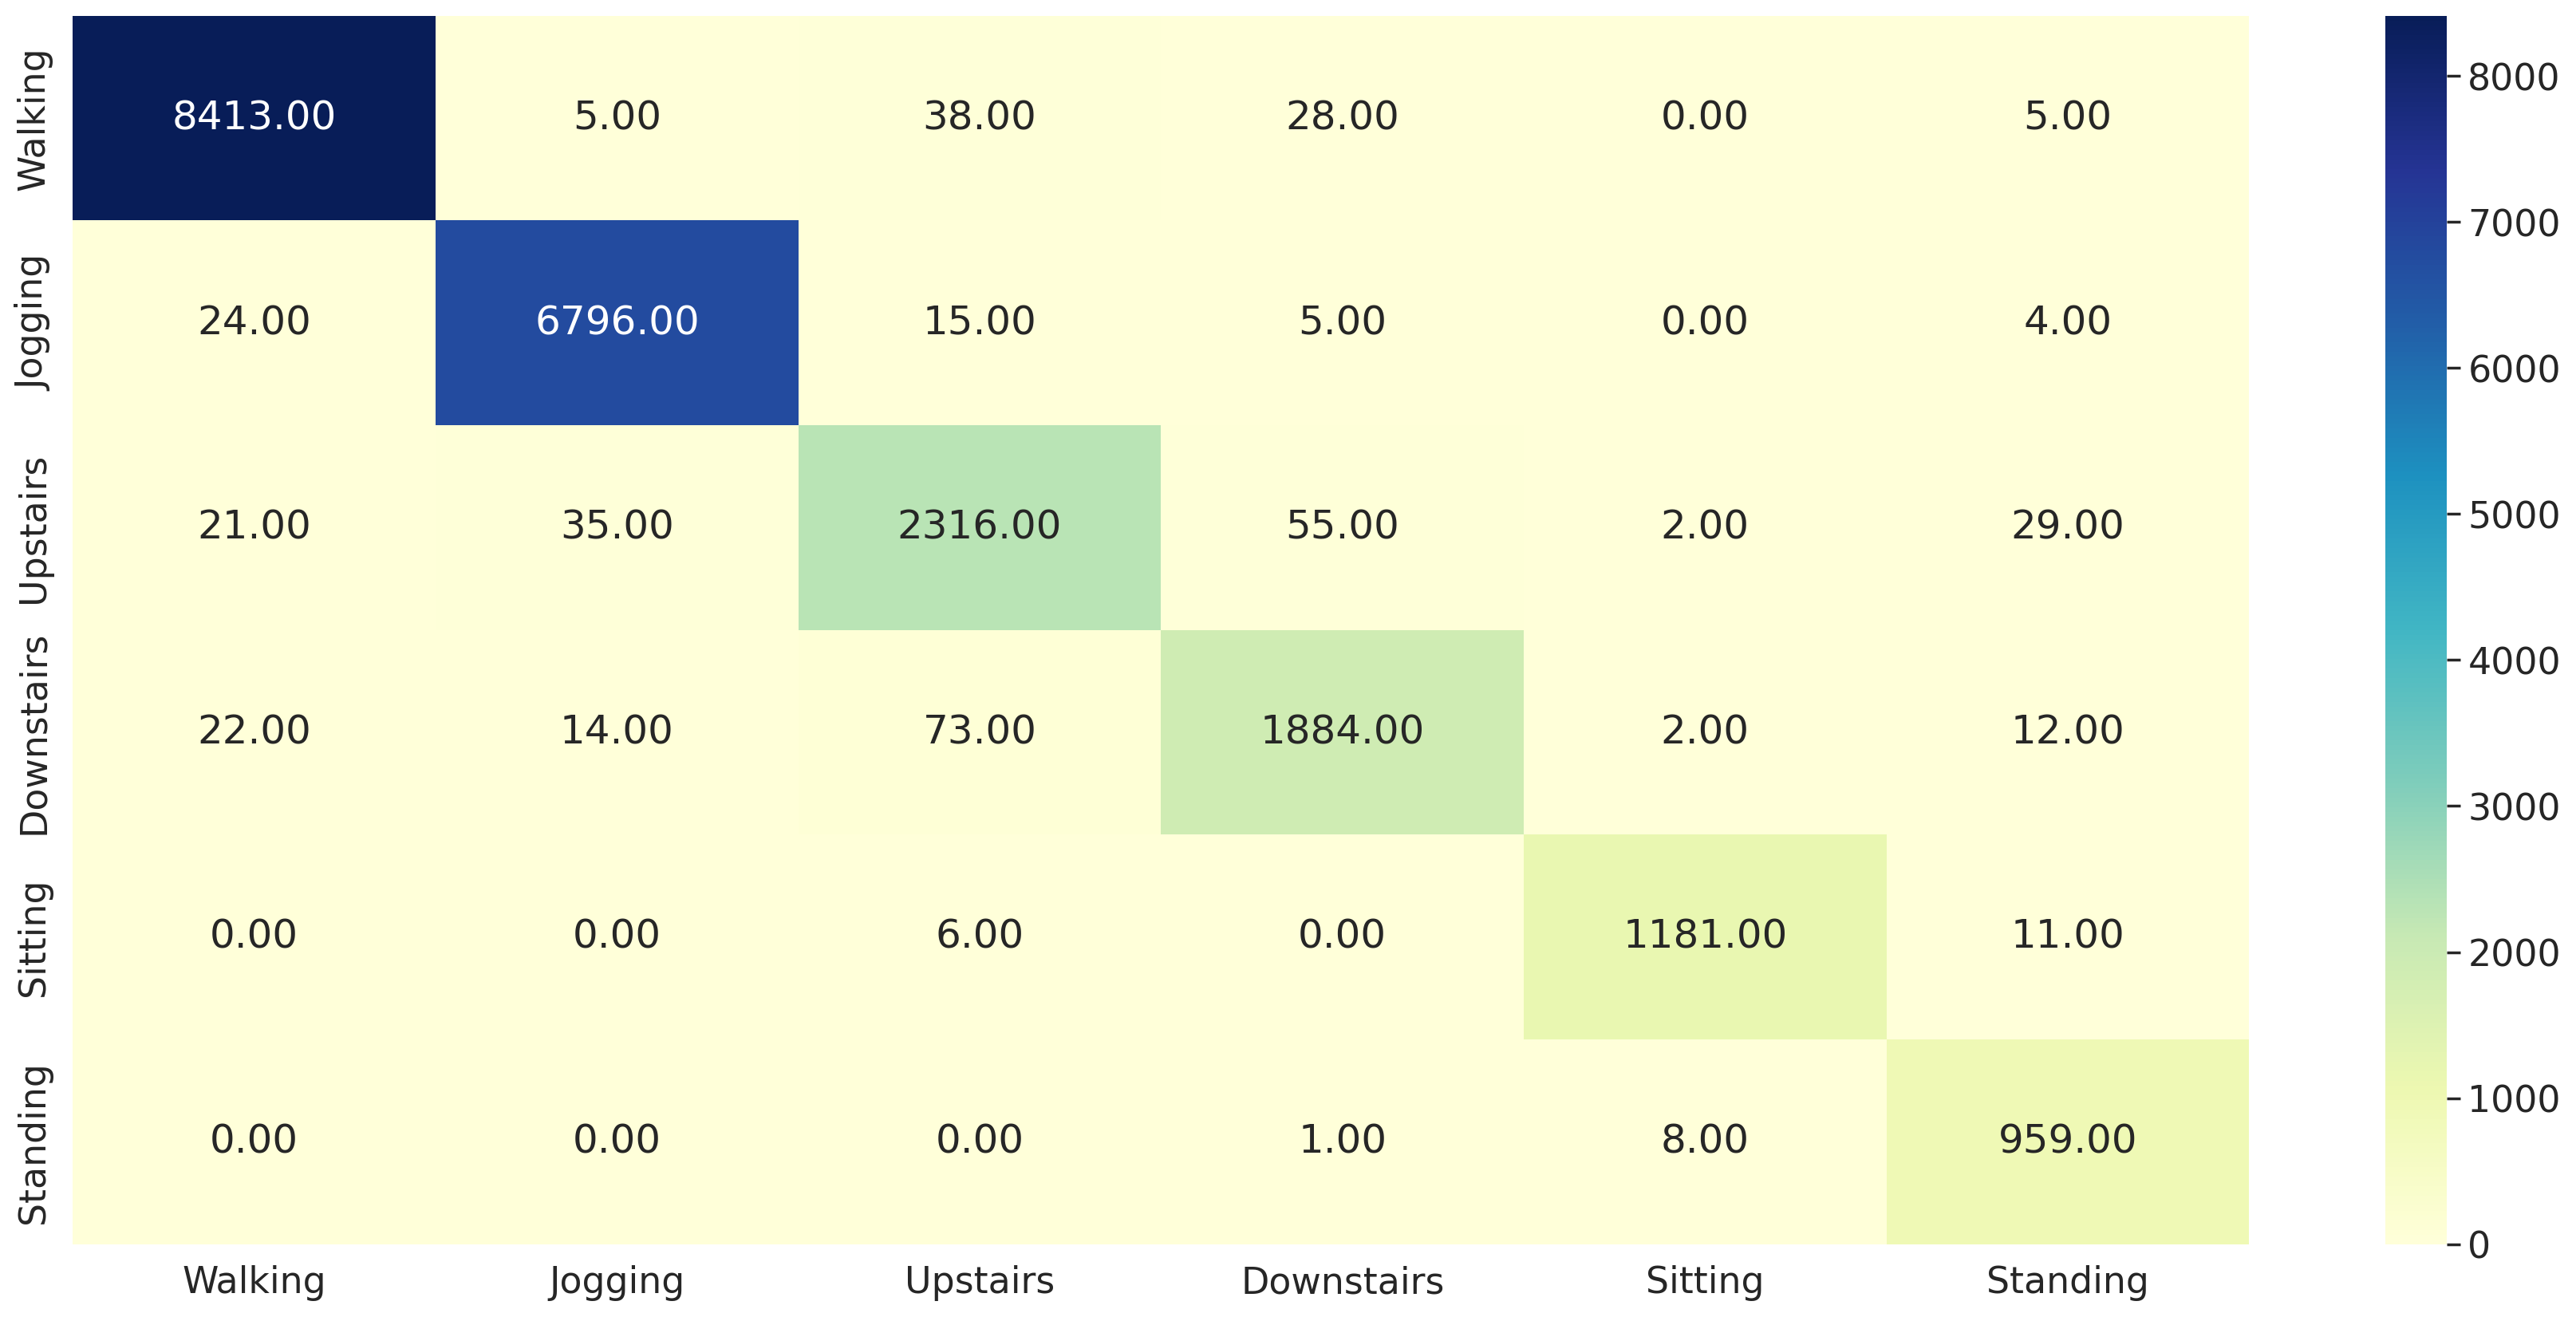

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM3

In [ ]:
model = Sequential()
# RNN layer
model.add(Bidirectional(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirecti  (None, 50, 256)           135168    
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_9 (Bidirecti  (None, 50, 256)           394240    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_10 (Bidirect  (None, 256)               394240    
 ional)                                                          
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 30s 34ms/step - loss: 0.5656 - accuracy: 0.8043 - val_loss: 0.3597 - val_accuracy: 0.8702
Epoch 2/10
550/550 [==============================] - 17s 30ms/step - loss: 0.2264 - accuracy: 0.9253 - val_loss: 0.1809 - val_accuracy: 0.9426
Epoch 3/10
550/550 [==============================] - 18s 32ms/step - loss: 0.1519 - accuracy: 0.9510 - val_loss: 0.1266 - val_accuracy: 0.9615
Epoch 4/10
550/550 [==============================] - 16s 30ms/step - loss: 0.1176 - accuracy: 0.9626 - val_loss: 0.1067 - val_accuracy: 0.9646
Epoch 5/10
550/550 [==============================] - 18s 33ms/step - loss: 0.0991 - accuracy: 0.9681 - val_loss: 0.0933 - val_accuracy: 0.9695
Epoch 6/10
550/550 [==============================] - 16s 30ms/step - loss: 0.0822 - accuracy: 0.9738 - val_loss: 0.0693 - val_accuracy: 0.9775
Epoch 7/10
550/550 [==============================] - 18s 32ms/step - loss: 0.0630 - accuracy: 0.9802 - val_loss: 0.0731 - val_accuracy:

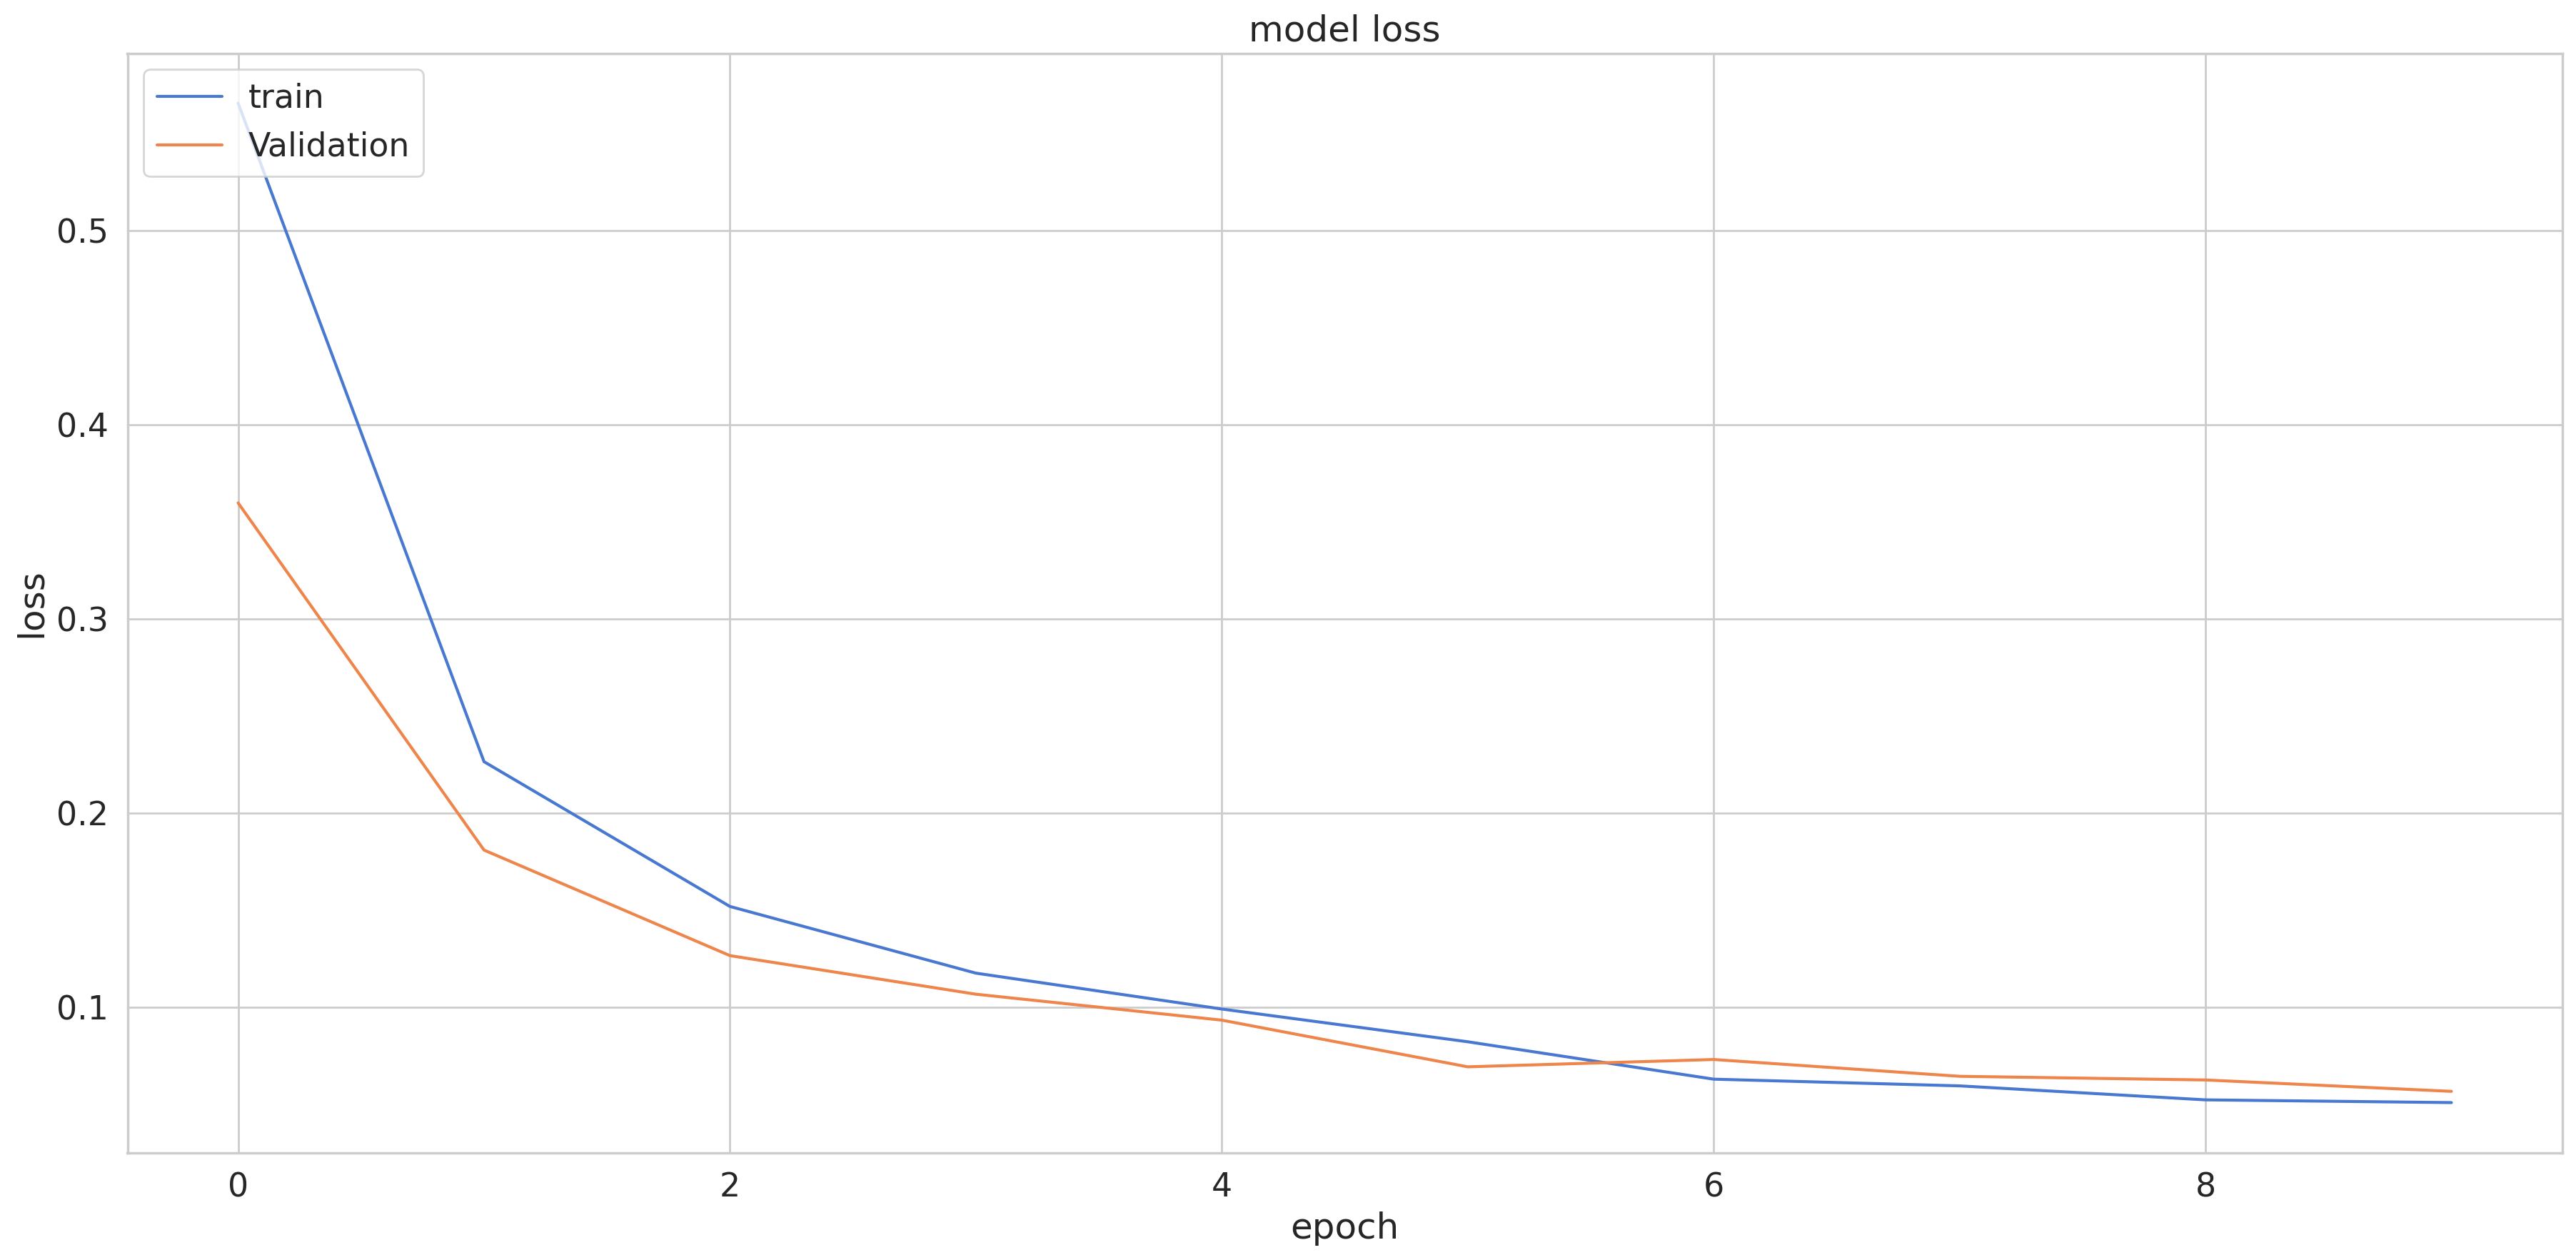

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

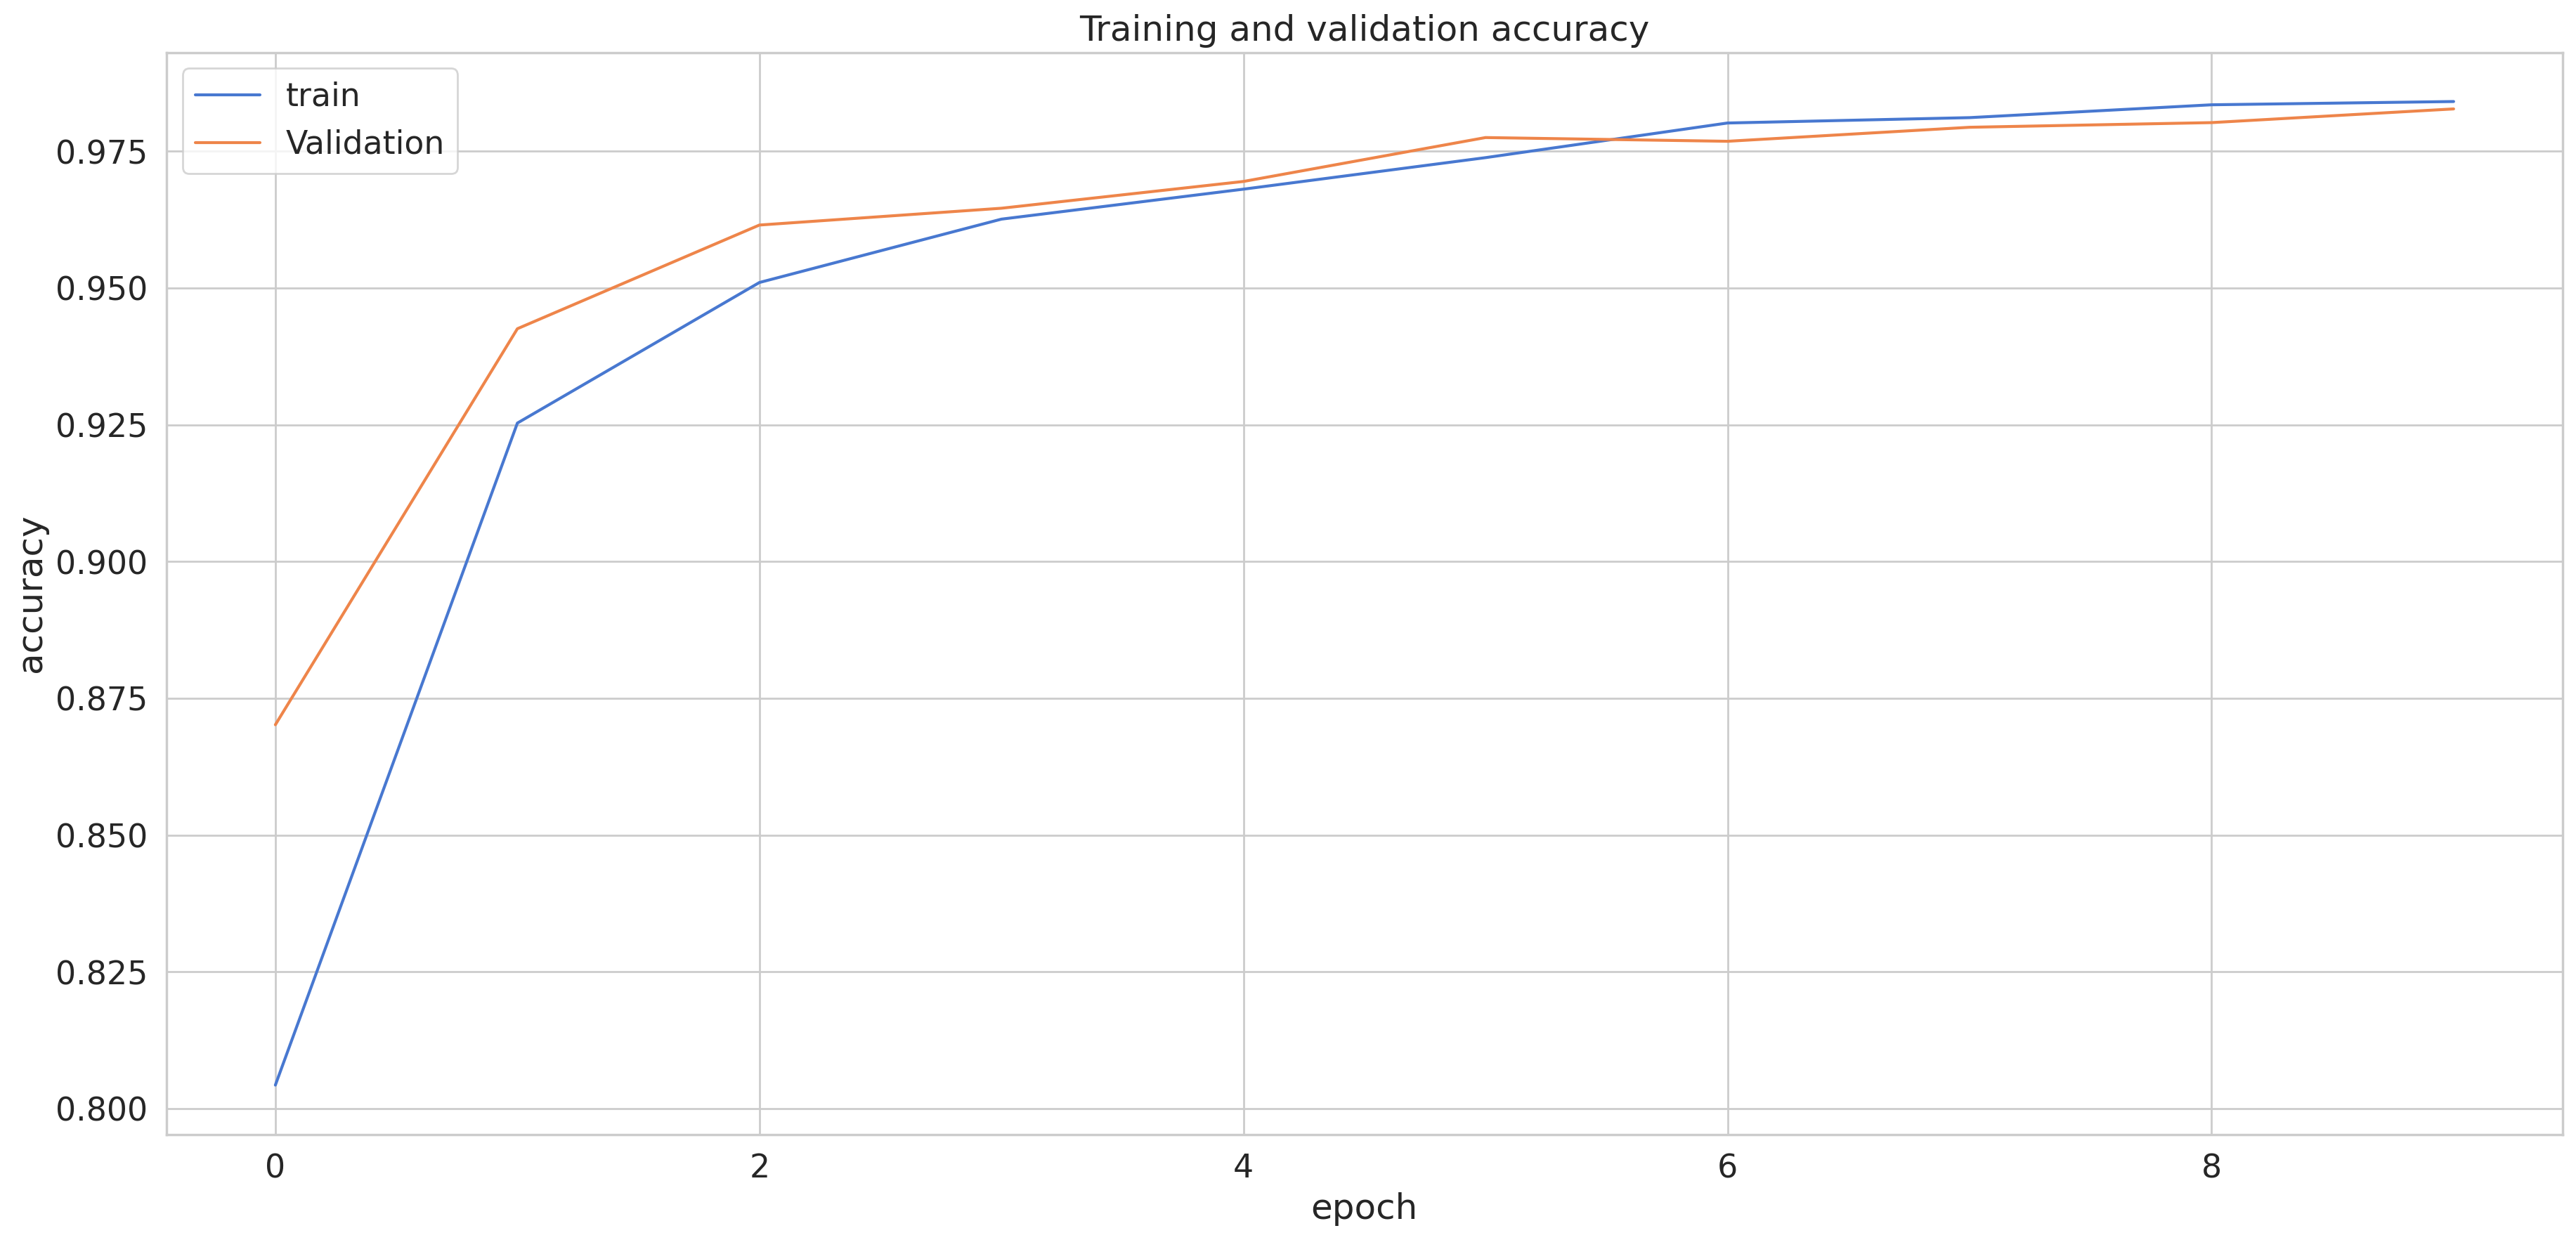

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 8s 9ms/step
f1_score =  0.9838982554422124
0.9839282462210891
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8489
           1       0.99      0.99      0.99      6844
           2       0.97      0.94      0.95      2458
           3       0.95      0.96      0.95      2007
           4       0.99      0.98      0.99      1198
           5       0.96      0.99      0.98       968

    accuracy                           0.98     21964
   macro avg       0.98      0.98      0.98     21964
weighted avg       0.98      0.98      0.98     21964



<Axes: >

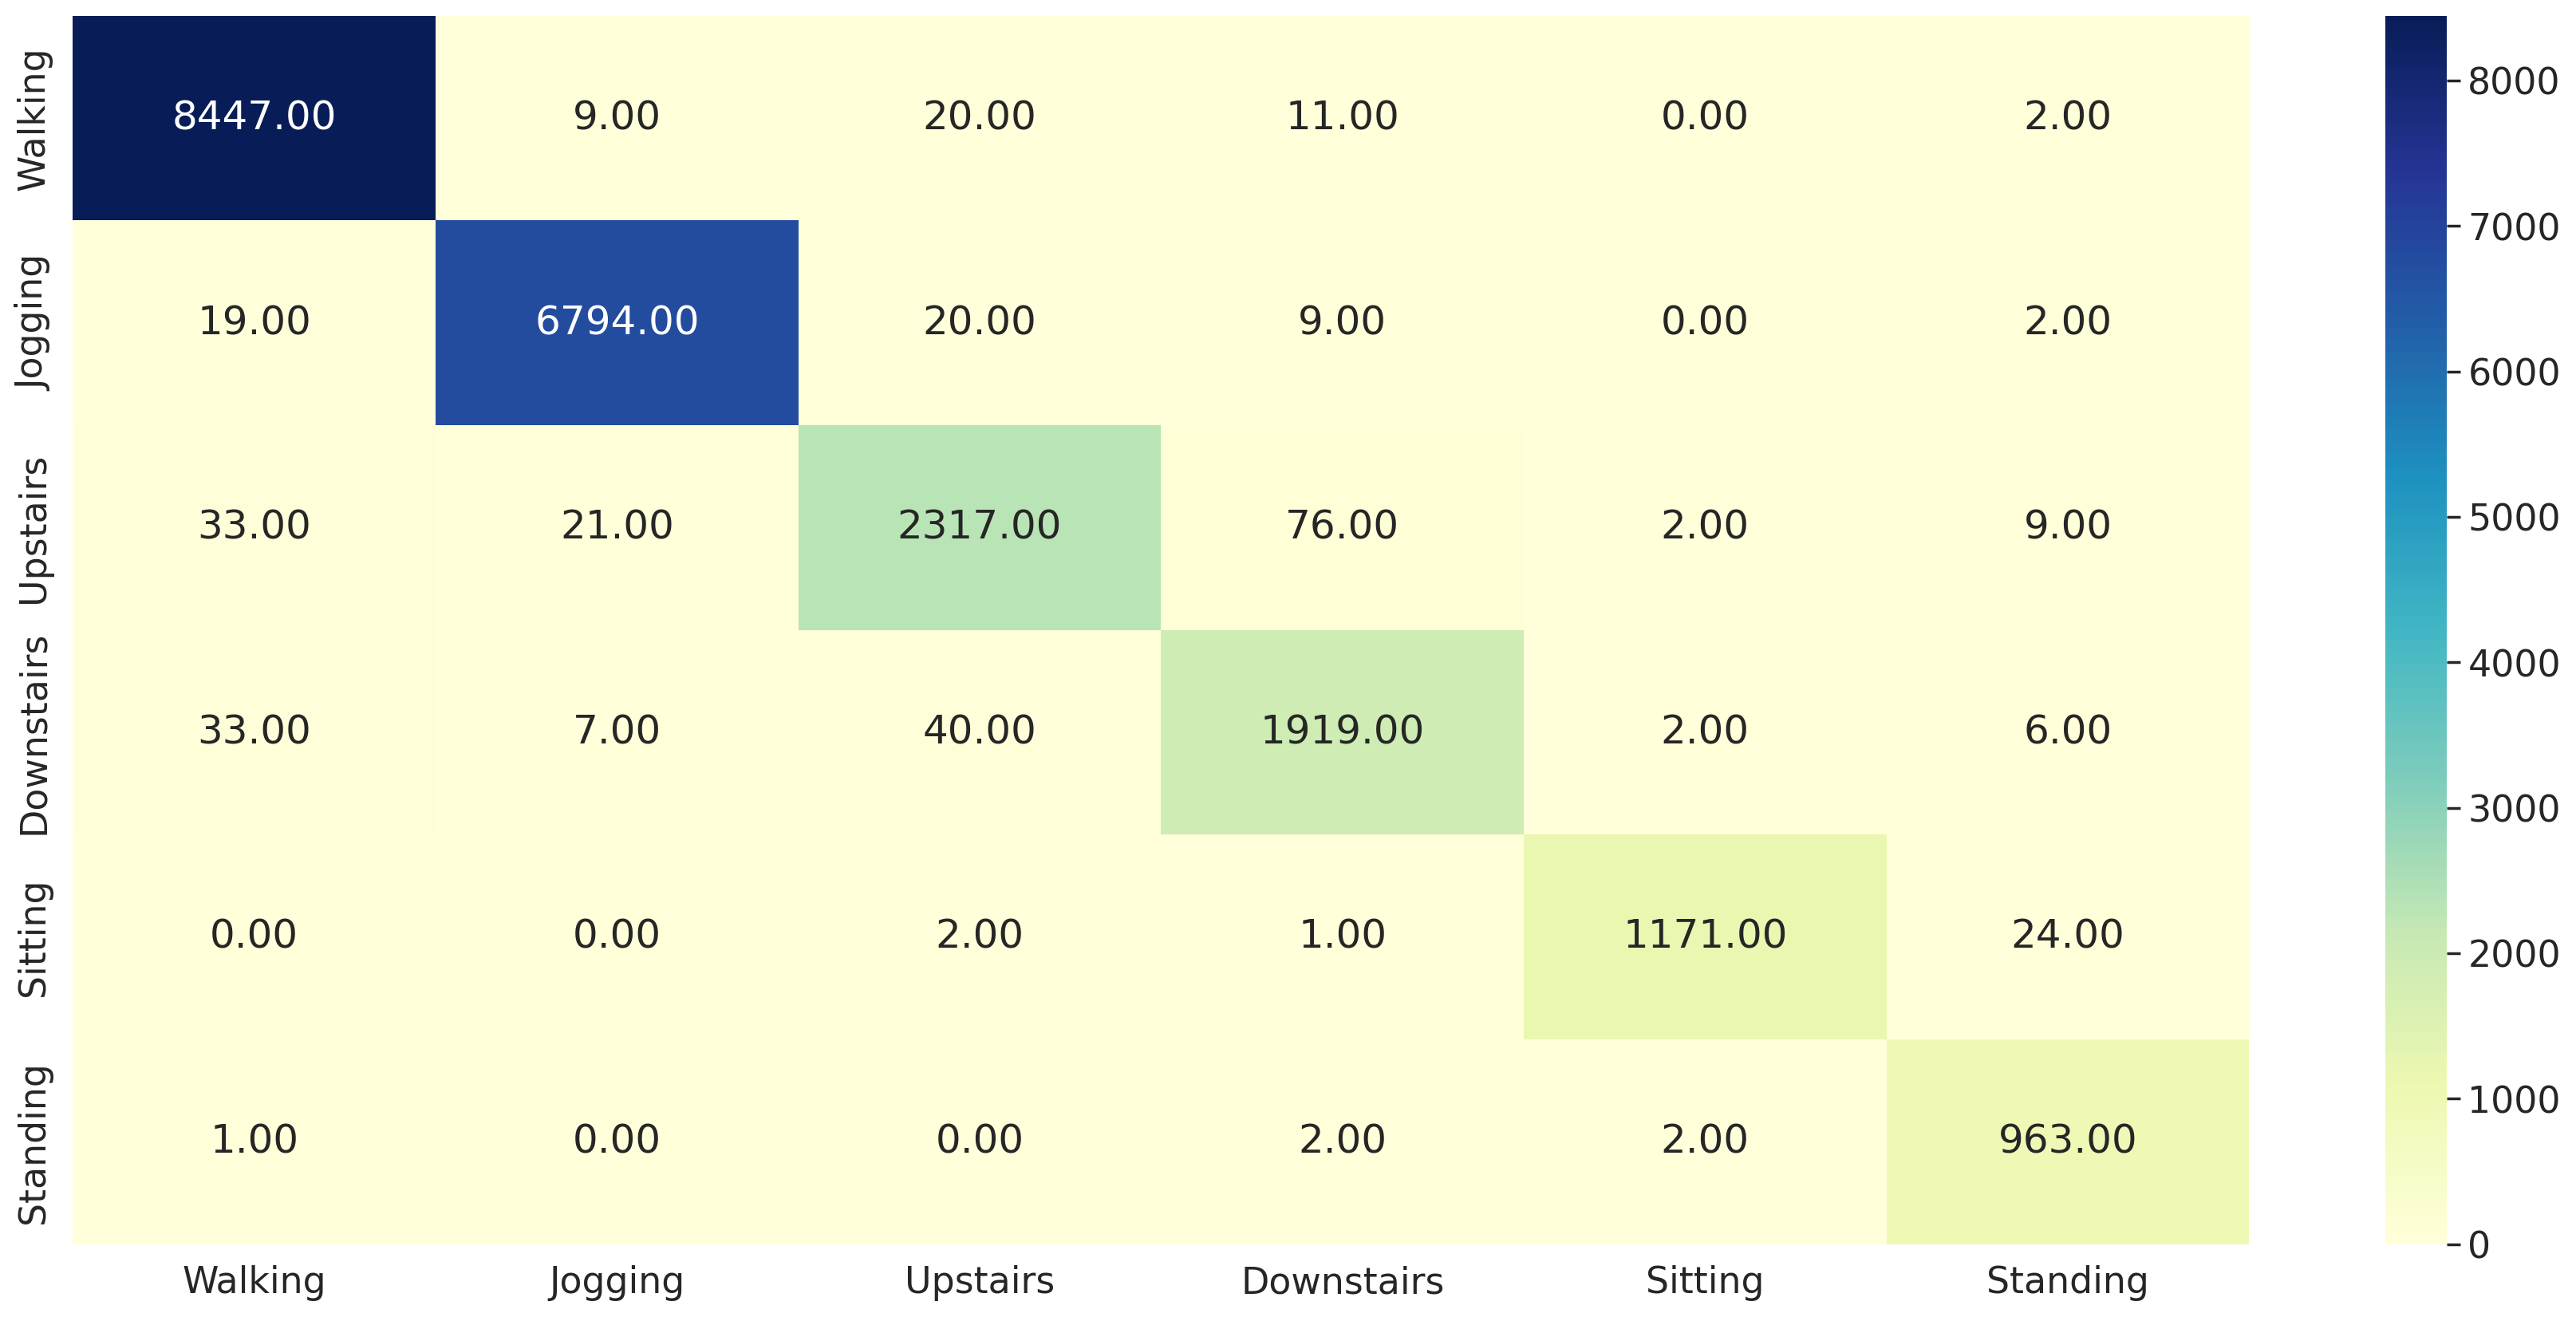

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM4

In [ ]:
model = Sequential()
# RNN layer
model.add(Bidirectional(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirect  (None, 50, 256)           135168    
 ional)                                                          
                                                                 
 dropout_11 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_12 (Bidirect  (None, 50, 256)           394240    
 ional)                                                          
                                                                 
 dropout_12 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_13 (Bidirect  (None, 50, 256)           394240    
 ional)                                                          
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 38s 46ms/step - loss: 0.6000 - accuracy: 0.7946 - val_loss: 0.4156 - val_accuracy: 0.8665
Epoch 2/10
550/550 [==============================] - 23s 41ms/step - loss: 0.2487 - accuracy: 0.9156 - val_loss: 0.1741 - val_accuracy: 0.9431
Epoch 3/10
550/550 [==============================] - 23s 41ms/step - loss: 0.1550 - accuracy: 0.9504 - val_loss: 0.1305 - val_accuracy: 0.9568
Epoch 4/10
550/550 [==============================] - 22s 40ms/step - loss: 0.1170 - accuracy: 0.9623 - val_loss: 0.0878 - val_accuracy: 0.9721
Epoch 5/10
550/550 [==============================] - 22s 41ms/step - loss: 0.0887 - accuracy: 0.9725 - val_loss: 0.0770 - val_accuracy: 0.9758
Epoch 6/10
550/550 [==============================] - 22s 40ms/step - loss: 0.0824 - accuracy: 0.9743 - val_loss: 0.0811 - val_accuracy: 0.9726
Epoch 7/10
550/550 [==============================] - 22s 41ms/step - loss: 0.0669 - accuracy: 0.9790 - val_loss: 0.0846 - val_accuracy:

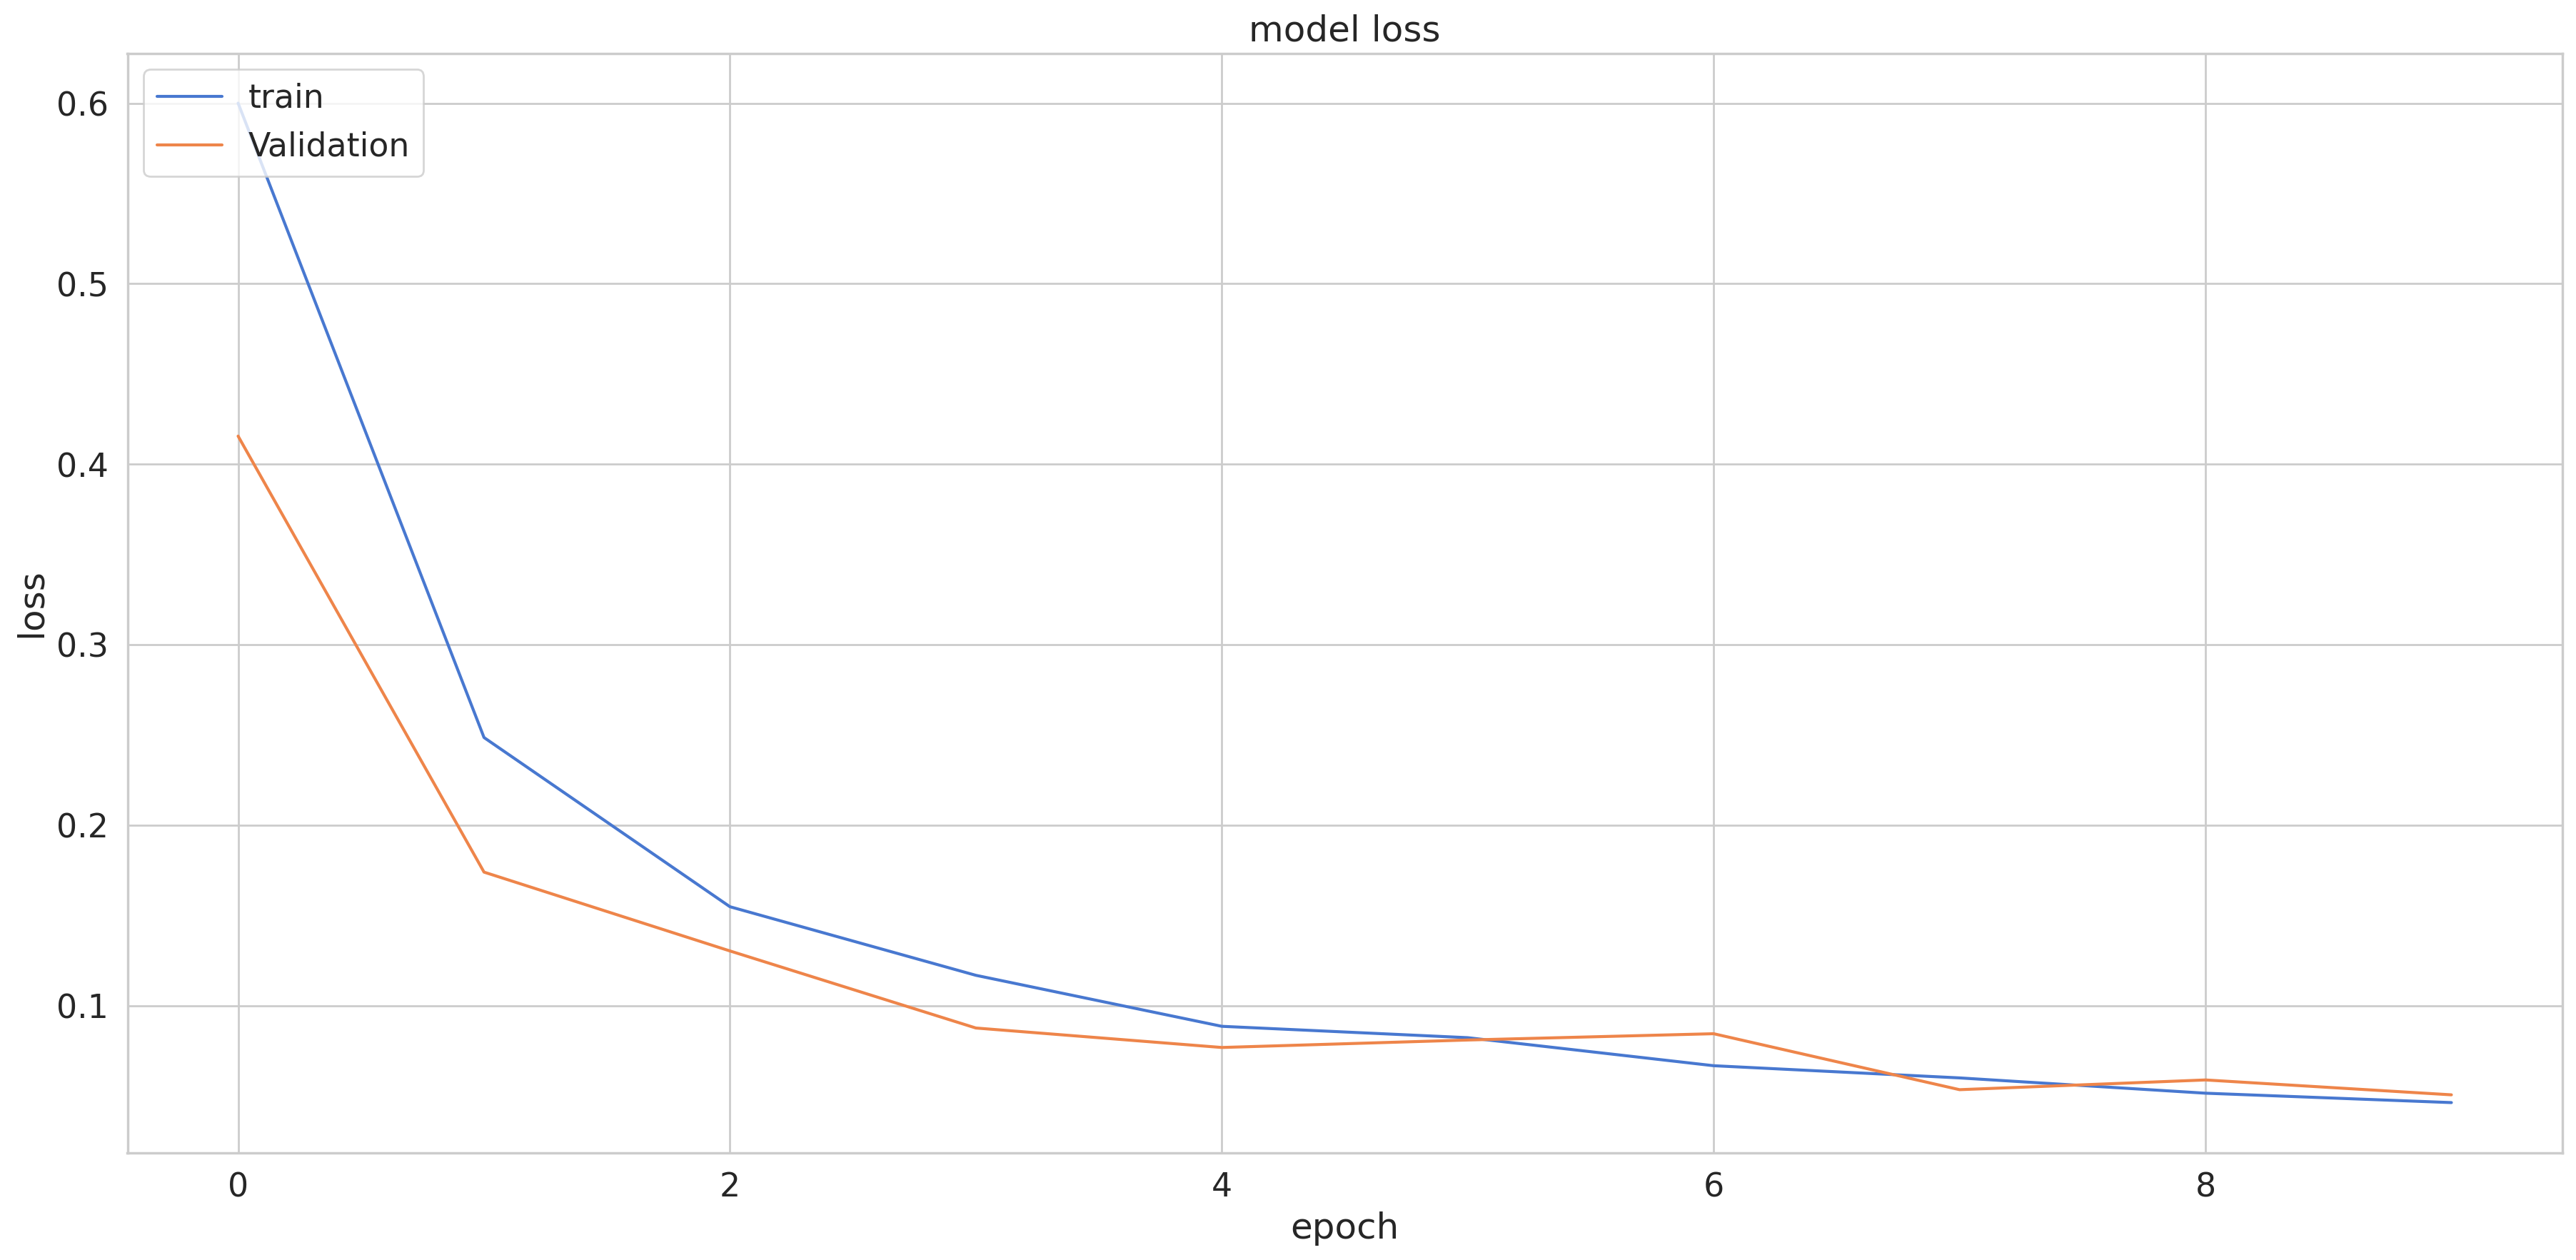

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

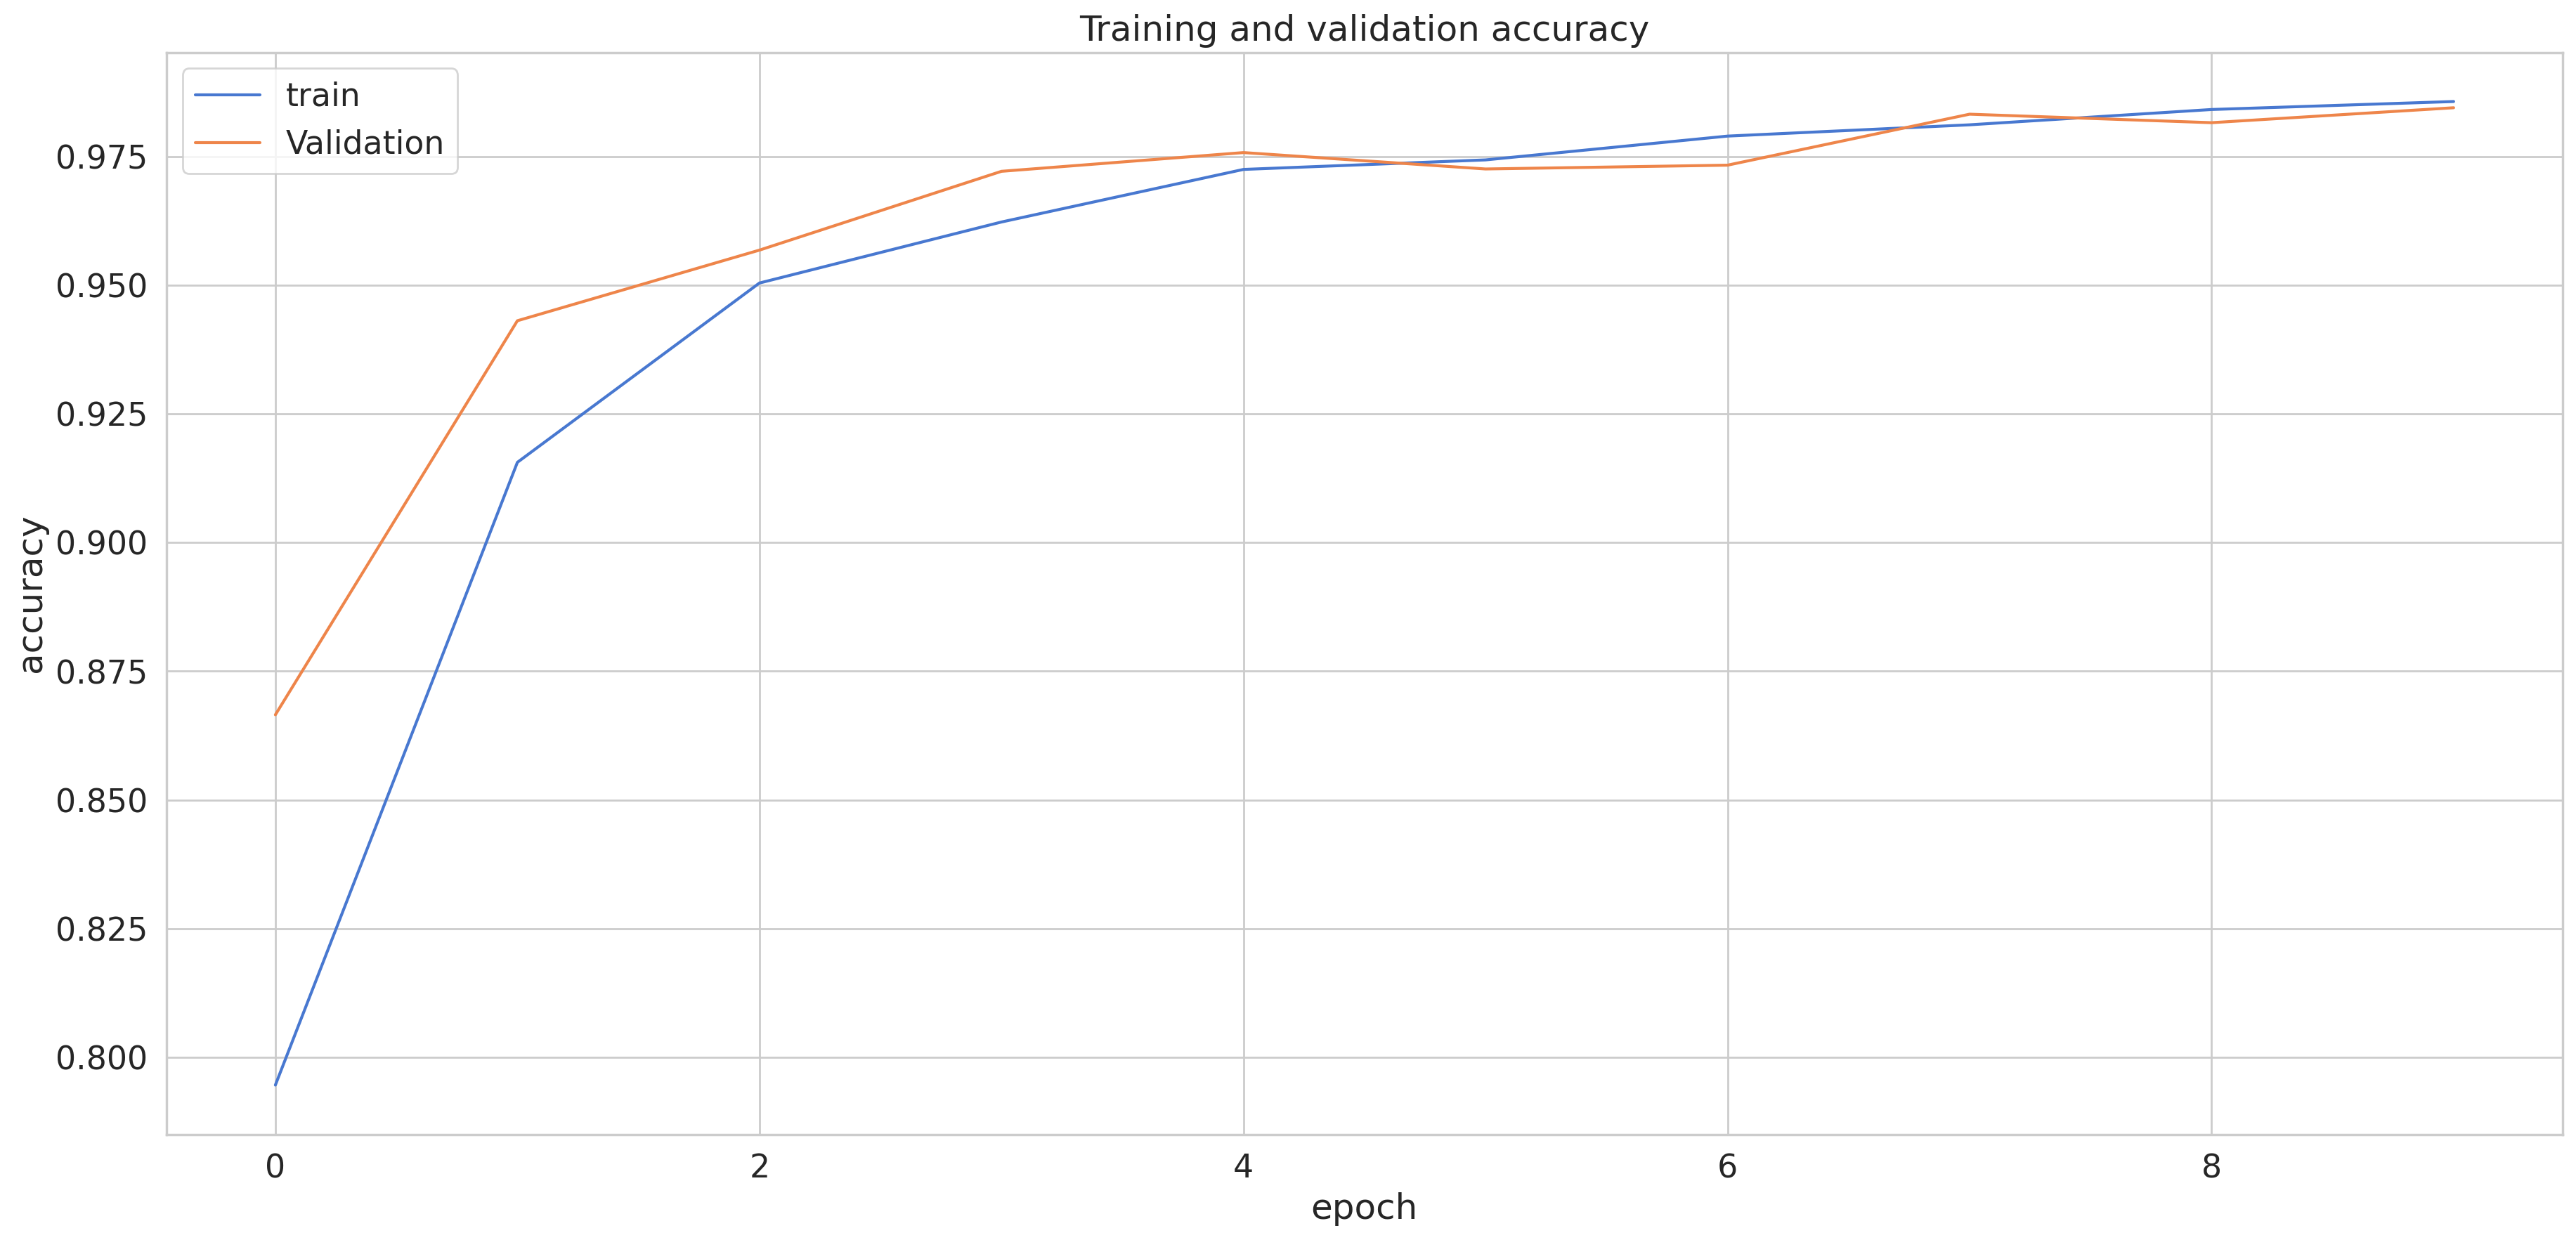

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 9s 9ms/step
f1_score =  0.9836216256569744
0.9836095428883628
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8489
           1       0.99      1.00      0.99      6844
           2       0.98      0.94      0.96      2458
           3       0.93      0.97      0.95      2007
           4       0.99      0.98      0.99      1198
           5       0.98      0.98      0.98       968

    accuracy                           0.98     21964
   macro avg       0.98      0.98      0.98     21964
weighted avg       0.98      0.98      0.98     21964



<Axes: >

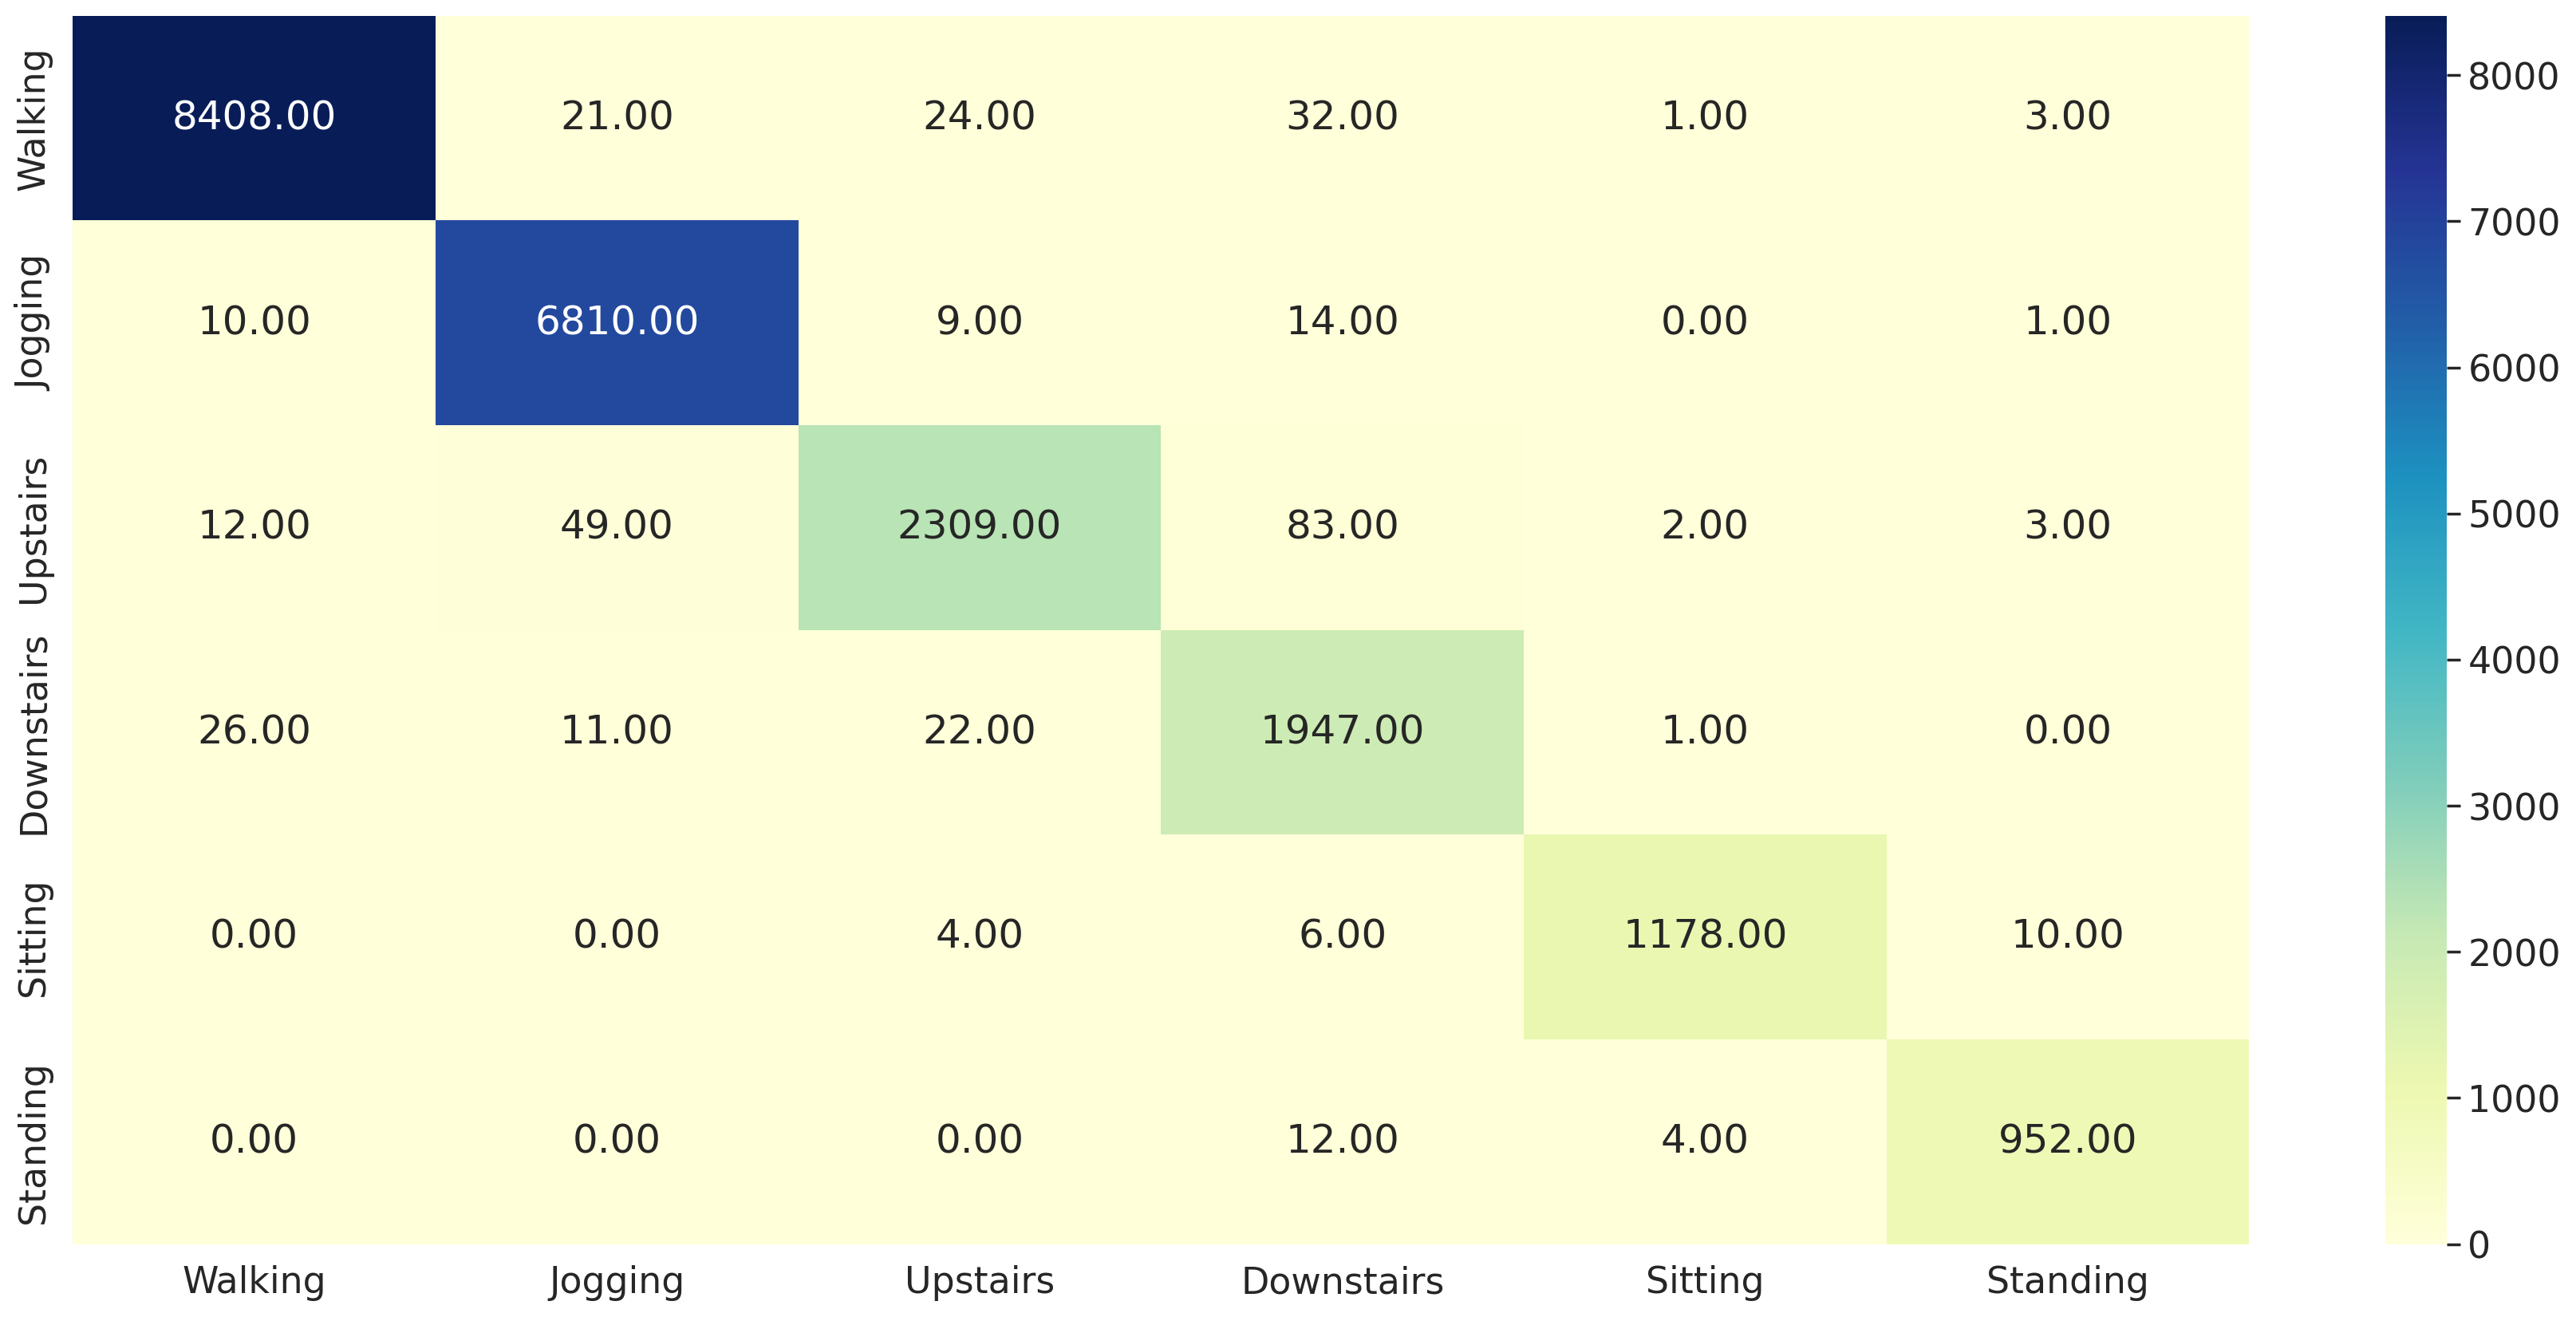

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM5

In [ ]:
model = Sequential()
# RNN layer
model.add(Bidirectional(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))


model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_15 (Bidirect  (None, 50, 256)           135168    
 ional)                                                          
                                                                 
 dropout_15 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_16 (Bidirect  (None, 50, 256)           394240    
 ional)                                                          
                                                                 
 dropout_16 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_17 (Bidirect  (None, 50, 256)           394240    
 ional)                                                          
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 47s 55ms/step - loss: 0.6036 - accuracy: 0.7945 - val_loss: 0.4134 - val_accuracy: 0.8653
Epoch 2/10
550/550 [==============================] - 28s 50ms/step - loss: 0.2462 - accuracy: 0.9212 - val_loss: 0.1767 - val_accuracy: 0.9431
Epoch 3/10
550/550 [==============================] - 27s 50ms/step - loss: 0.1659 - accuracy: 0.9466 - val_loss: 0.1622 - val_accuracy: 0.9487
Epoch 4/10
550/550 [==============================] - 27s 49ms/step - loss: 0.1257 - accuracy: 0.9603 - val_loss: 0.1059 - val_accuracy: 0.9664
Epoch 5/10
550/550 [==============================] - 27s 50ms/step - loss: 0.1031 - accuracy: 0.9668 - val_loss: 0.0960 - val_accuracy: 0.9704
Epoch 6/10
550/550 [==============================] - 27s 50ms/step - loss: 0.0848 - accuracy: 0.9734 - val_loss: 0.0858 - val_accuracy: 0.9734
Epoch 7/10
550/550 [==============================] - 30s 54ms/step - loss: 0.0747 - accuracy: 0.9762 - val_loss: 0.0774 - val_accuracy:

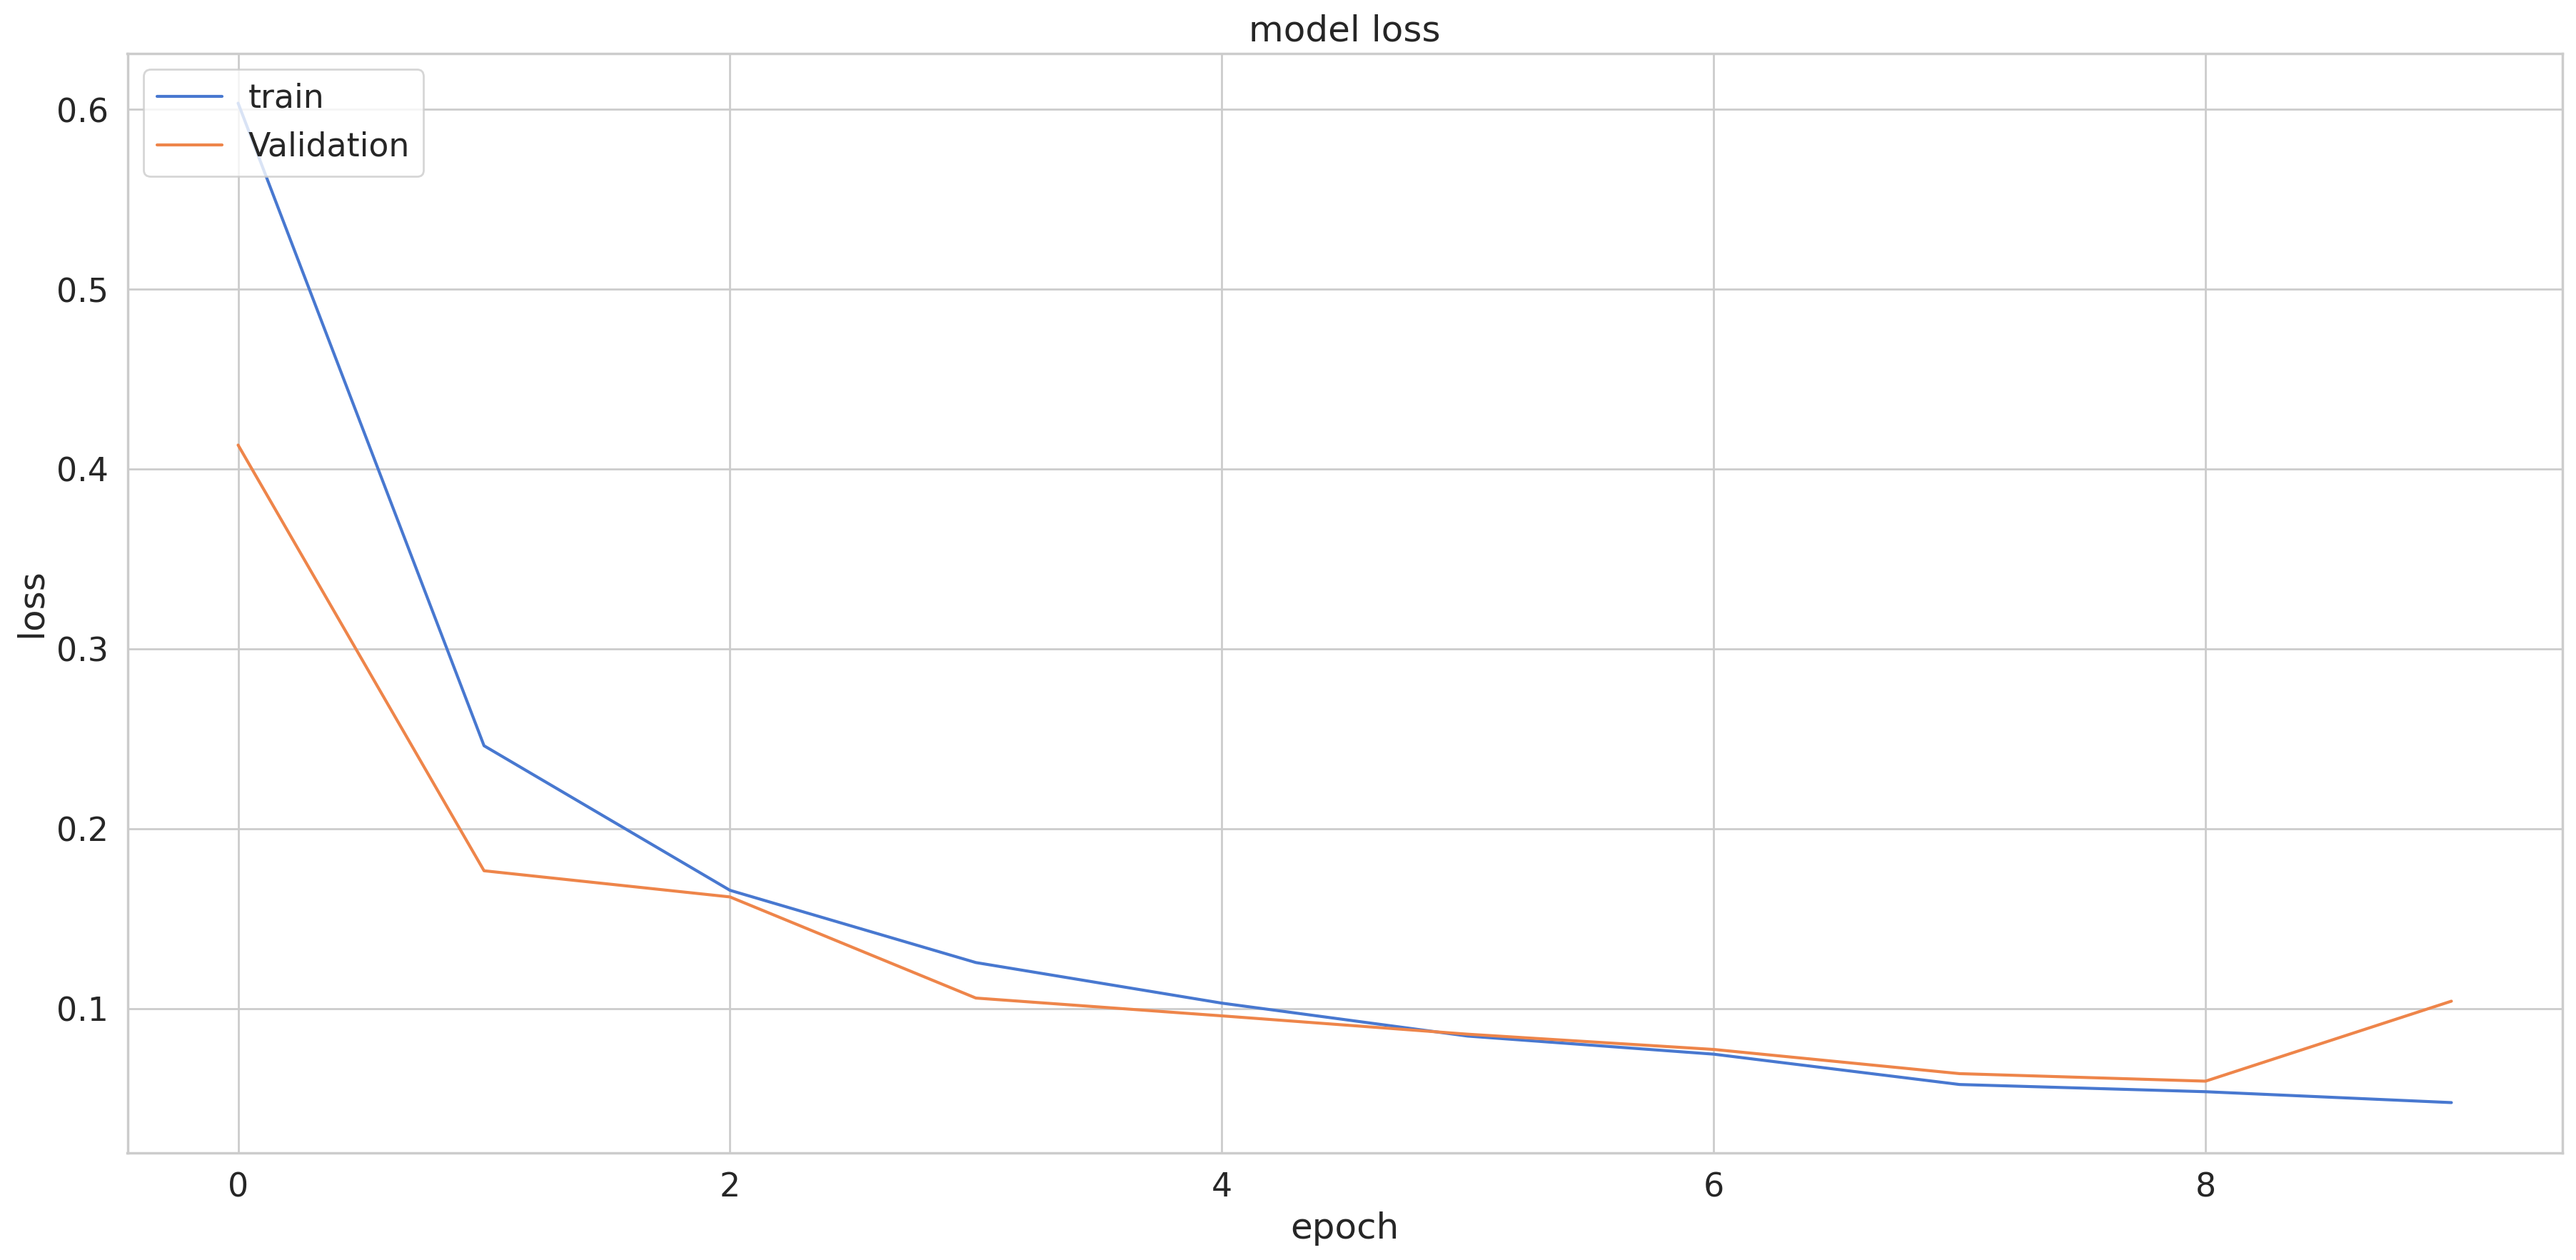

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

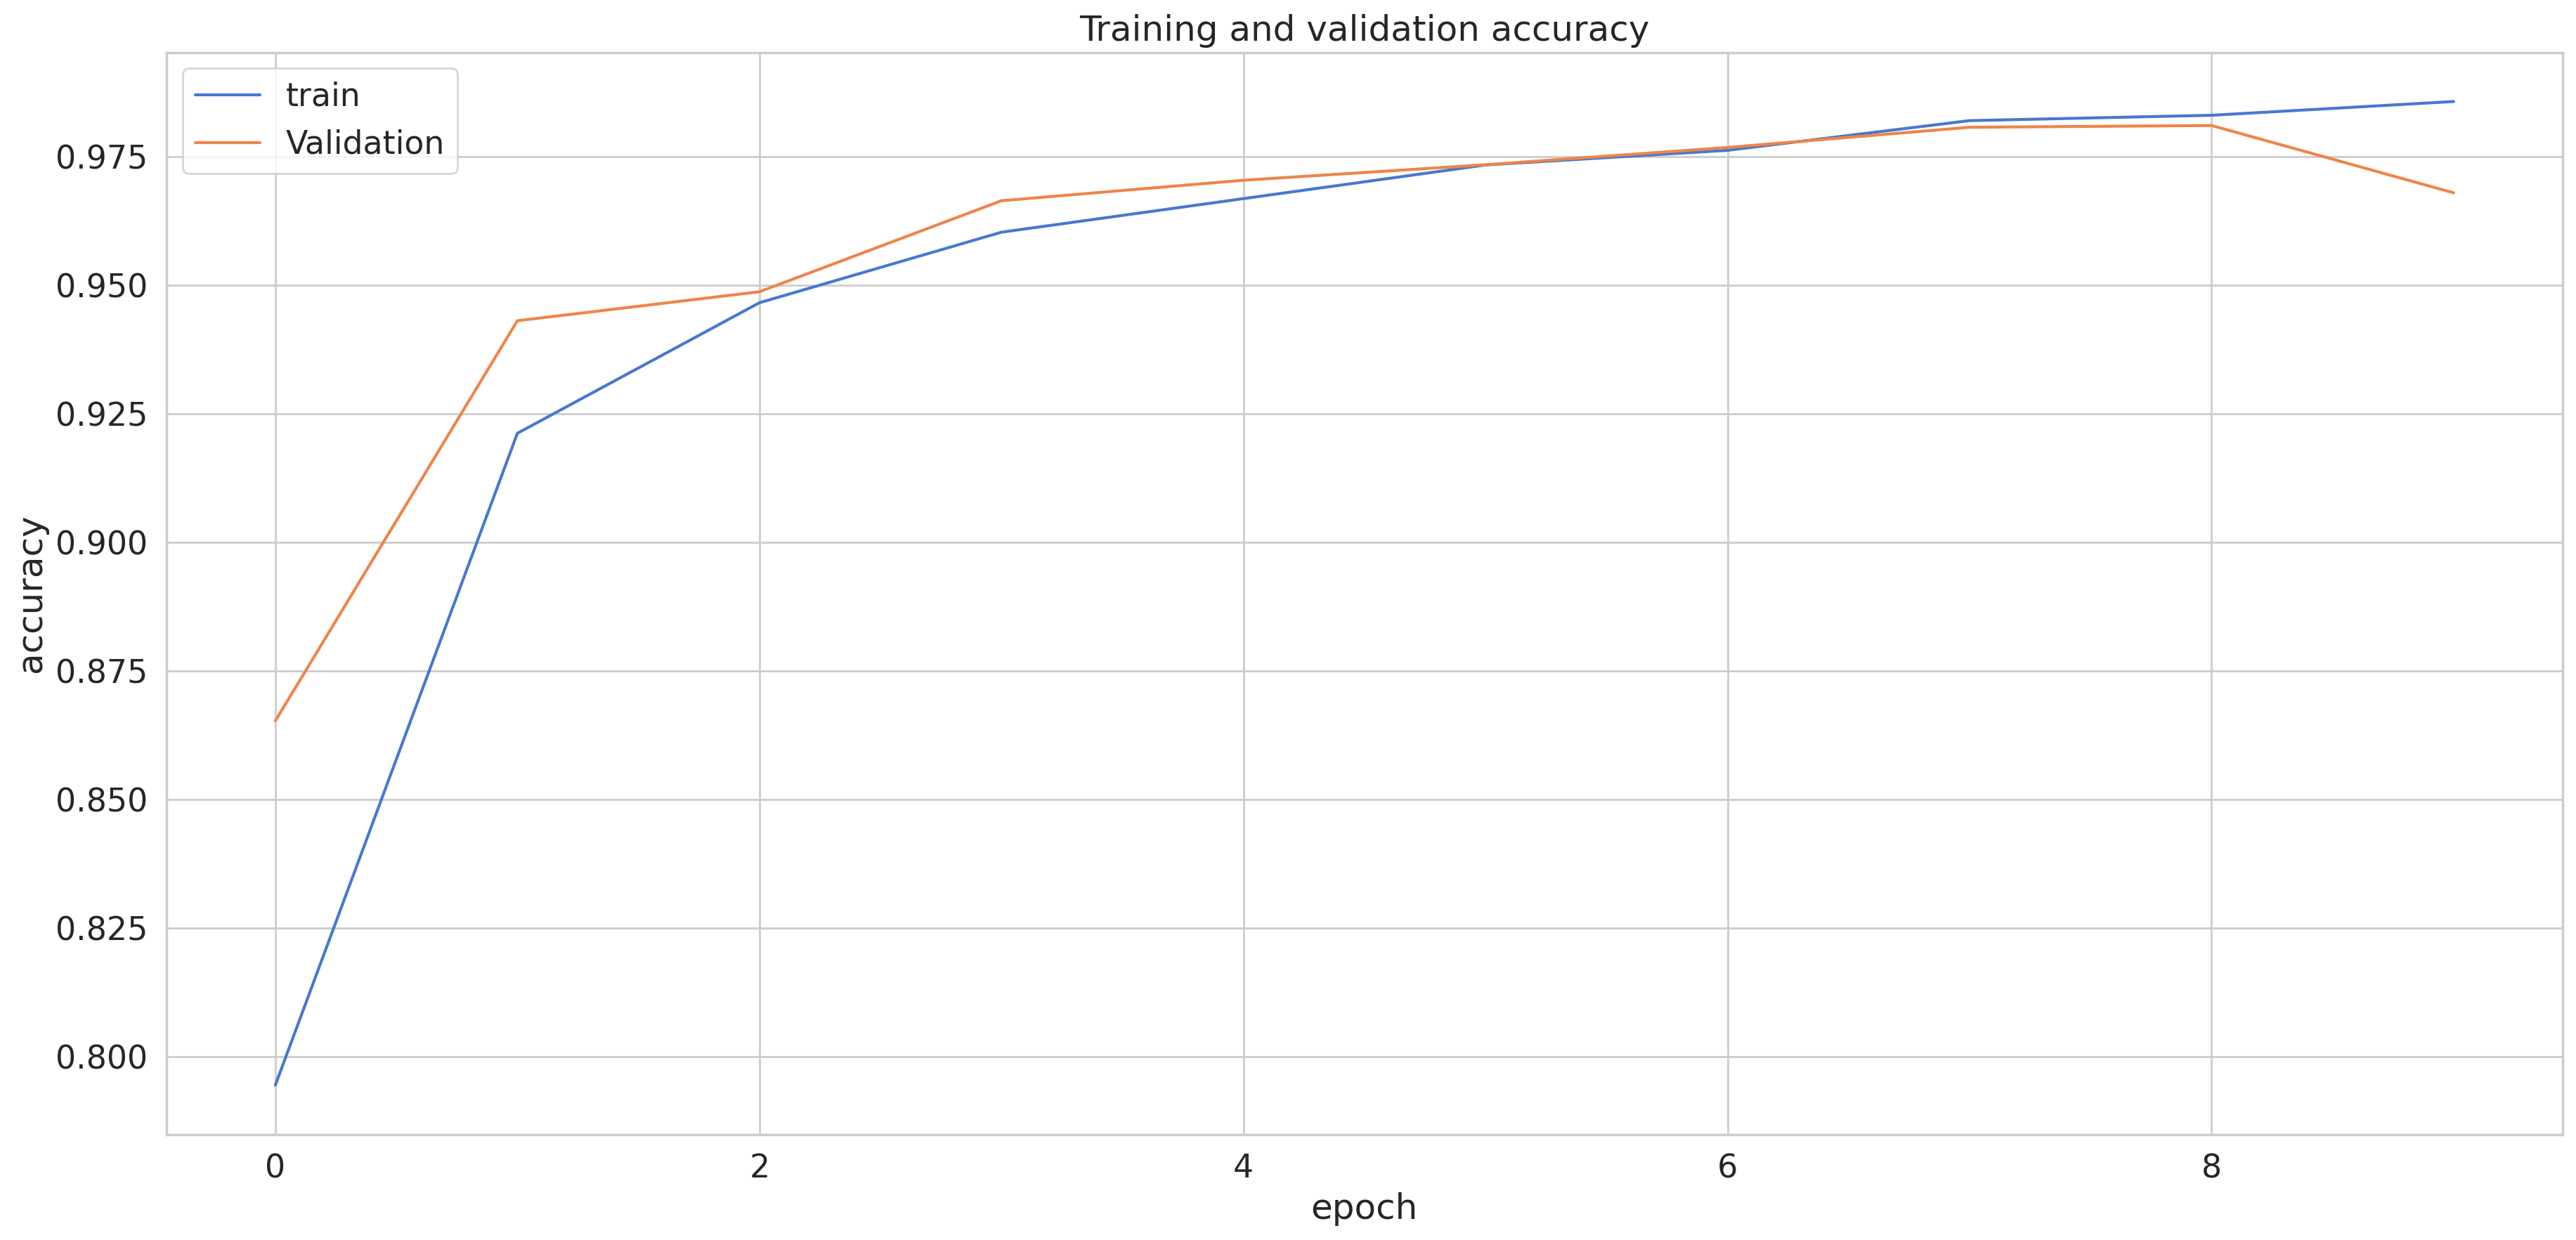

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 10s 11ms/step
f1_score =  0.9687448803458535
0.9684483700600983
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      8489
           1       0.99      0.99      0.99      6844
           2       0.89      0.98      0.93      2458
           3       0.89      0.91      0.90      2007
           4       0.99      0.99      0.99      1198
           5       0.98      0.99      0.98       968

    accuracy                           0.97     21964
   macro avg       0.96      0.97      0.96     21964
weighted avg       0.97      0.97      0.97     21964



<Axes: >

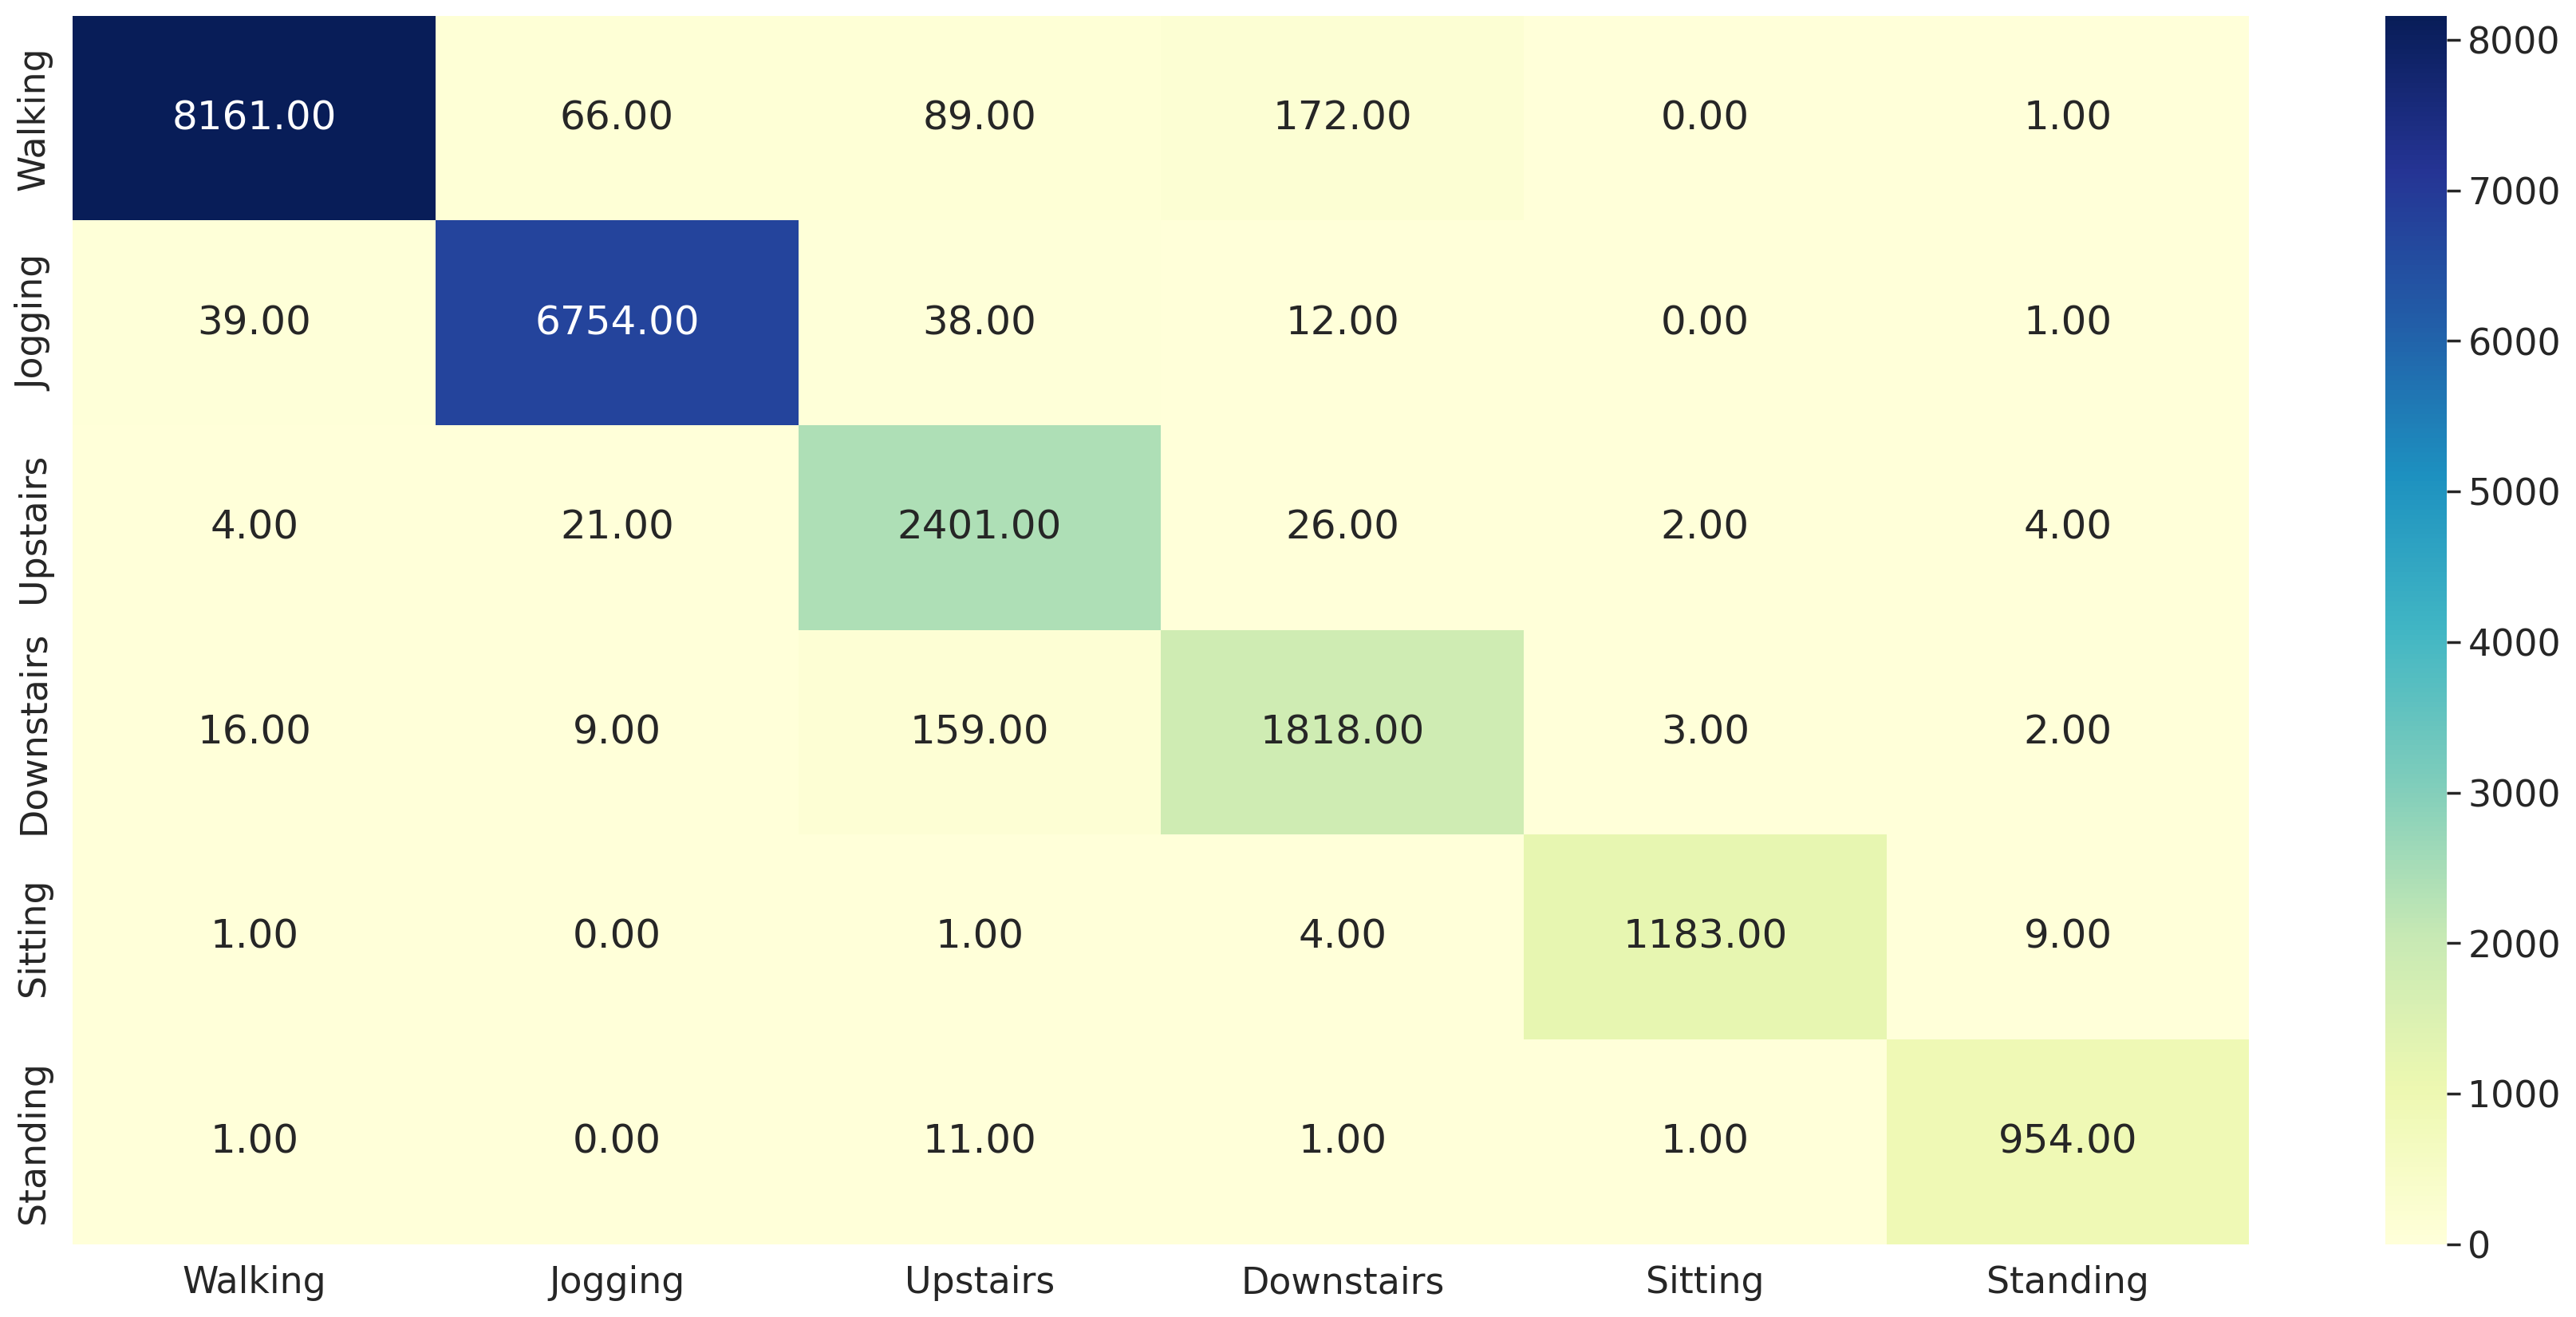

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')